# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [82]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

In [83]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from functools import reduce

In [84]:
from mpl_toolkits.mplot3d import Axes3D
from IPython import display

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [85]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

In [86]:
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [87]:
azdias.tail(2)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
891219,-1,1,1,3.0,1,5,3,5,5,5,...,1.0,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0
891220,-1,4,1,1.0,4,2,5,2,1,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,4.0,5.0


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. This file will be used to help make cleaning decisions during this stage of the project. 

The demographics data will first be assessed to find missing data.

<Axes: >

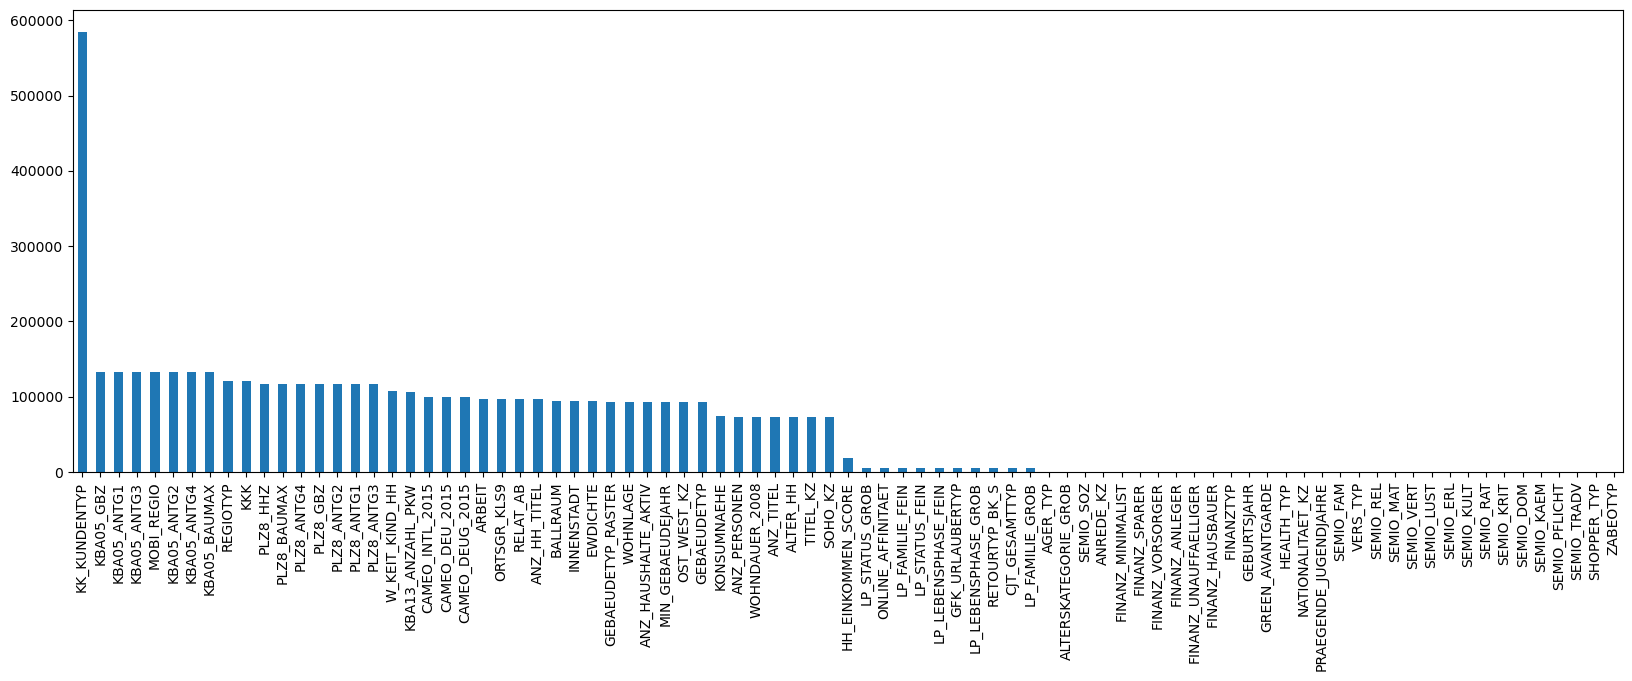

In [88]:
azdias.isnull().sum().sort_values(ascending =False).plot.bar(figsize=(20,6))

In [89]:
val = azdias.isnull().sum().sort_values(ascending =False)
print('Features with the top most null values')
val[:15]

Features with the top most null values


KK_KUNDENTYP    584612
KBA05_GBZ       133324
KBA05_ANTG1     133324
KBA05_ANTG3     133324
MOBI_REGIO      133324
KBA05_ANTG2     133324
KBA05_ANTG4     133324
KBA05_BAUMAX    133324
REGIOTYP        121196
KKK             121196
PLZ8_HHZ        116515
PLZ8_BAUMAX     116515
PLZ8_ANTG4      116515
PLZ8_GBZ        116515
PLZ8_ANTG2      116515
dtype: int64

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [90]:
def covert_Nan(df2):
    df = df2.copy(deep=True)
    for row, feature_col in enumerate(df.iteritems()):
        col_name = feature_col[0]
        NaN_values = feat_info['missing_or_unknown'][row]
        NaN_values = NaN_values.replace(']','').replace('[','')
        NaN_values = NaN_values.replace('"','').split(",")
        NaN_values1 = []
        #print(col_name, NaN_values)
        if(len(NaN_values)==1 and NaN_values[0]==''):
            pass
        else:
            for i in NaN_values:
                if i in ['X', 'XX']:
                    NaN_values1.append(i)
                else:
                    NaN_values1.append(int(i))
                    #print(NaN_values1)
            df[col_name] = df[col_name].replace(NaN_values1,np.nan)
    return df

In [91]:
azdias = covert_Nan(azdias)

/var/folders/tk/l8jl358x18q85155m0fs7ldh0000gn/T/ipykernel_76912/1869644172.py:3: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for row, feature_col in enumerate(df.iteritems()):


In [92]:
no_of_null_initial = azdias.isnull().sum().sum()
print('Null', no_of_null_initial)

Null 8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [93]:
# NOTE: This function was taken from stackoverflow at this link 
# https://stackoverflow.com/questions/26266362/how-to-count-the-nan-values-in-a-column-in-pandas-dataframe
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        return mis_val_table_ren_columns


In [94]:
missingVal = missing_values_table(azdias)
outlier =missingVal['% of Total Values'].sort_values(ascending =False)

In [95]:
# Perform an assessment of how much missing data there is in each column of the dataset.
print('Top 25 features with outliers')
outlier[:13]

Top 25 features with outliers


TITEL_KZ          99.8
AGER_TYP          77.0
KK_KUNDENTYP      65.6
KBA05_BAUMAX      53.5
GEBURTSJAHR       44.0
ALTER_HH          34.8
KKK               17.7
REGIOTYP          17.7
W_KEIT_KIND_HH    16.6
KBA05_GBZ         15.0
MOBI_REGIO        15.0
KBA05_ANTG4       15.0
KBA05_ANTG3       15.0
Name: % of Total Values, dtype: float64

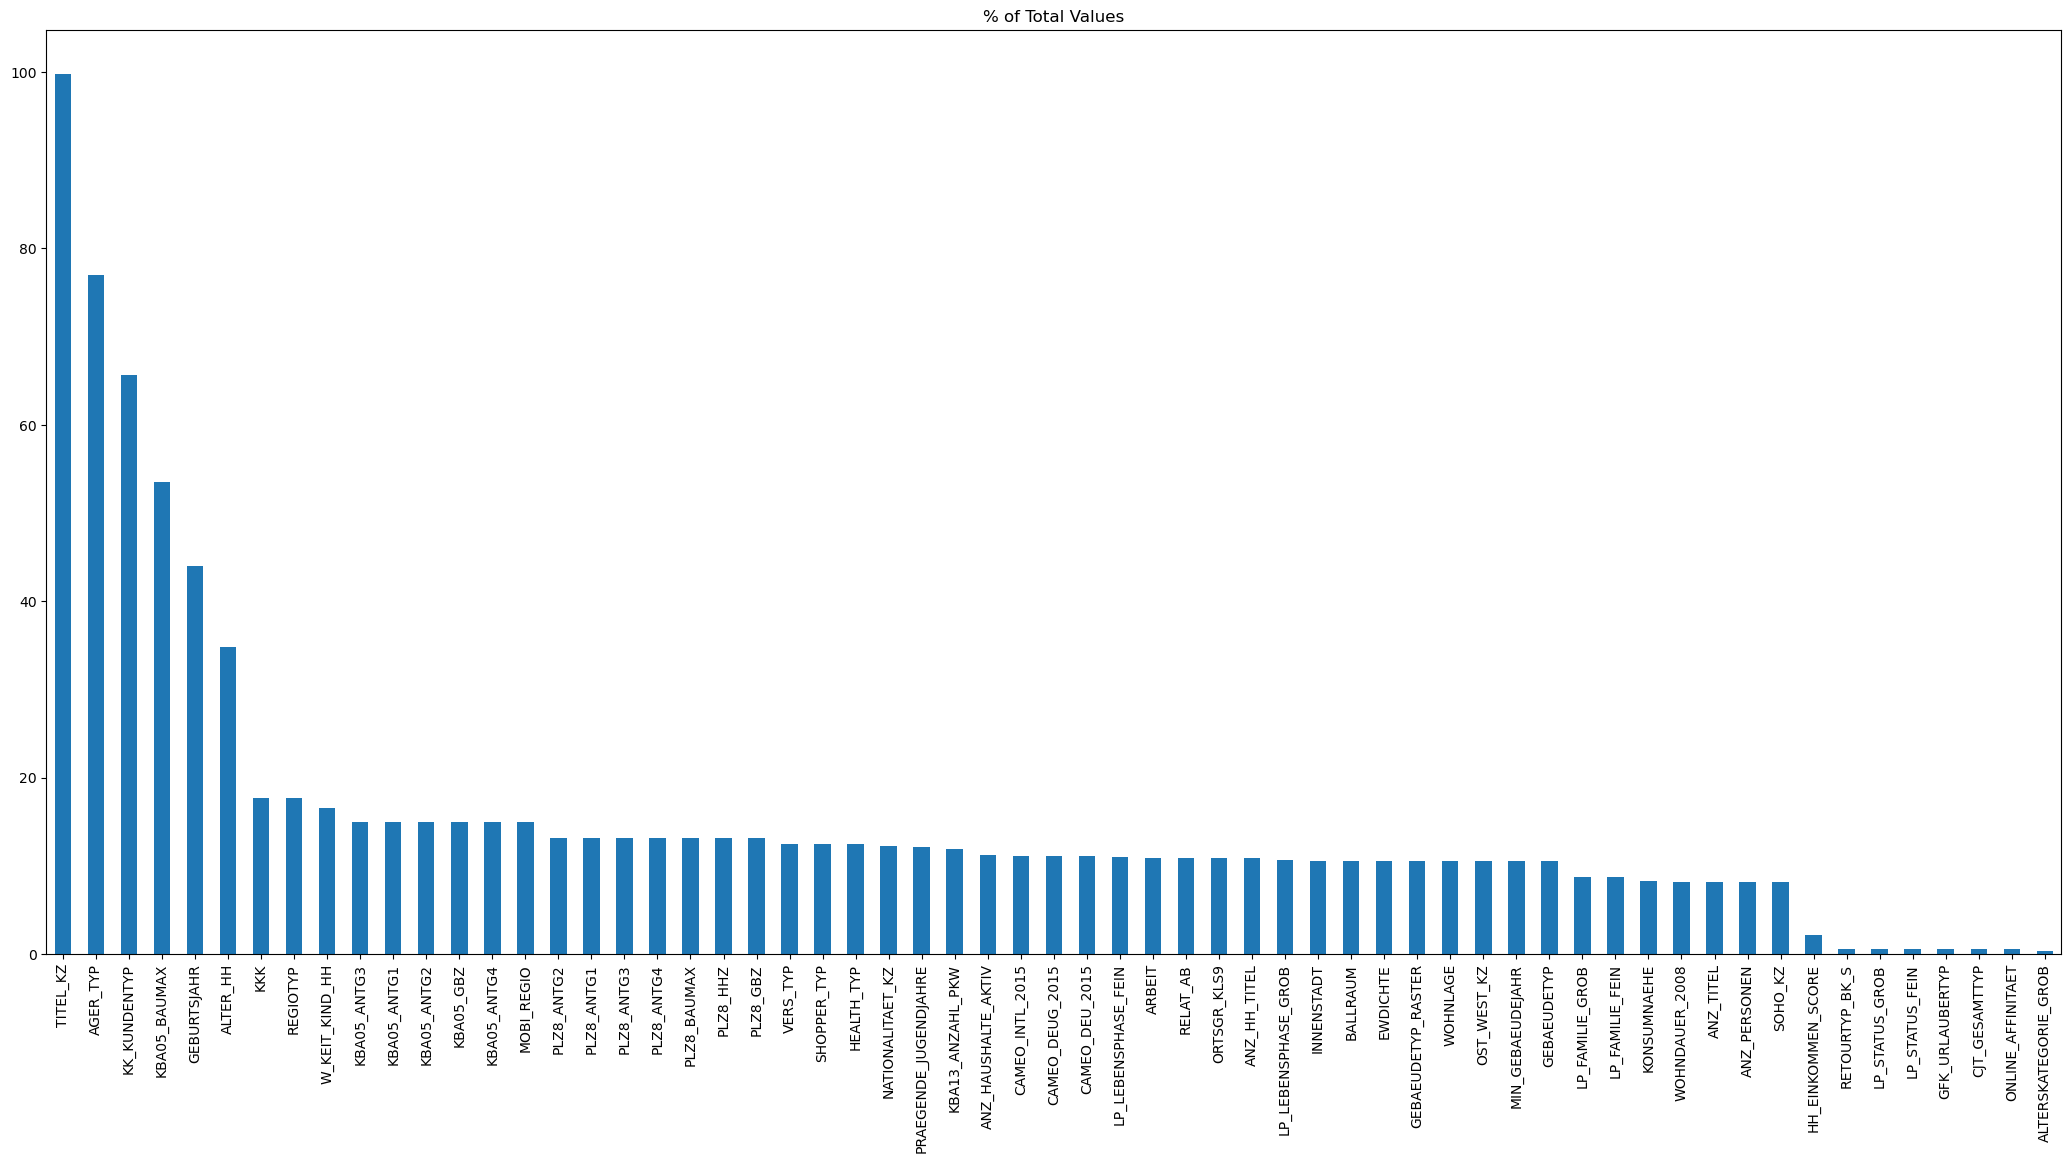

In [96]:
# Investigate patterns in the amount of missing data in each column.
missingVal['% of Total Values'].plot.bar(subplots=True, figsize=(26,12));


<b>The top 5 most significant features with outliers included the following: </b>
    
TITEL_KZ - Academic title flag         <br>
AGER_TYP     - Best-ager typology    <br>
KK_KUNDENTYP  - Consumer pattern over past 12 months   <br>
KBA05_BAUMAX  - Most common building type within the microcell   <br>
GEBURTSJAHR   - Year of birth   <br>
<hr>

In [97]:
# Remove the outlier columns from the dataset.
outliers = outlier.keys().tolist()
for i in outliers[:6]:
    print('Dropping feature', i)
    azdias.drop(columns=i, inplace=True)

Dropping feature TITEL_KZ
Dropping feature AGER_TYP
Dropping feature KK_KUNDENTYP
Dropping feature KBA05_BAUMAX
Dropping feature GEBURTSJAHR
Dropping feature ALTER_HH


In [98]:
no_of_null_after = azdias.isnull().sum().sum()
print('Null Values before:', no_of_null_initial)
print('Null Values after:',no_of_null_after)
print('Difference', no_of_null_initial - no_of_null_after)


Null Values before: 8373929
Null Values after: 5035304
Difference 3338625


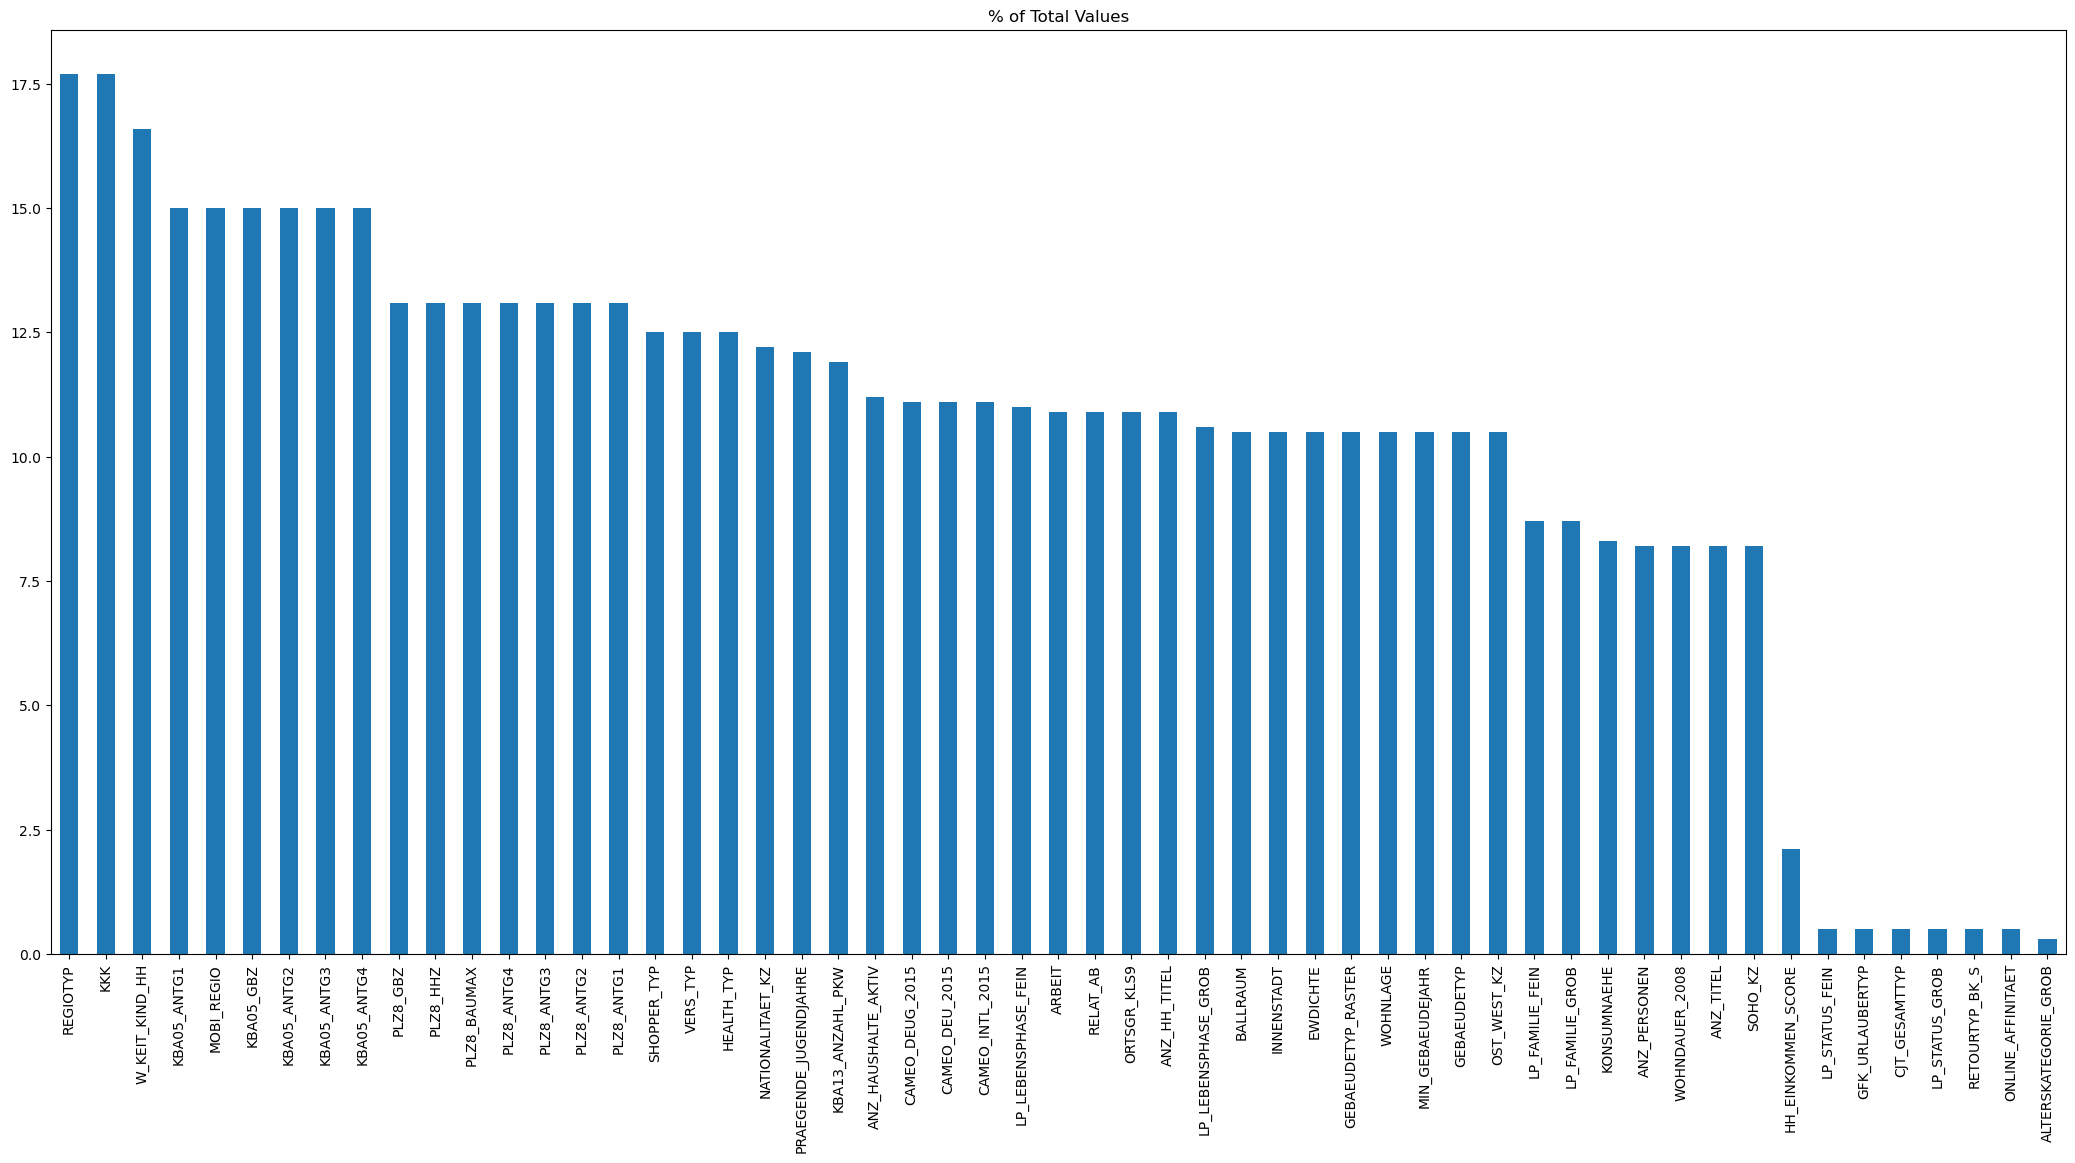

In [99]:
missingVal_aft = missing_values_table(azdias)
missingVal_aft['% of Total Values'].plot.bar(subplots=True, figsize=(26,12));

### Analysis

**Top 6 Most Significant Features with Outliers Included:**

1. TITEL_KZ - Academic title flag
2. AGER_TYP - Best-ager typology
3. KK_KUNDENTYP - Consumer pattern over the past 12 months
4. KBA05_BAUMAX - Most common building type within the microcell
5. GEBURTSJAHR - Year of birth
6. ALTER_HH - Birthdate of head of household

**Observations:**
- TITEL_KZ has the highest number of missing values (>90%), but its removal would likely have minimal impact on the data and clustering algorithm.
- Features like KK_KUNDENTYP and GEBURTSJAHR provide information about years of birth, while others like KBA05_BAUMAX could potentially be useful.

**Top 6 Most Significant Features with Fewest Outliers:**

1. REGIOTYP - Neighborhood typology
2. KKK - Purchasing power in the region
3. W_KEIT_KIND_HH - Likelihood of children in household
4. KBA05_ANTG1 - Number of 1-2 family houses in the microcell
5. MOBI_REGIO - Movement patterns
6. KBA05_GBZ - Number of buildings in the microcell

**Observations:**
- These features describe economic and social aspects of demography, such as purchasing power, movement patterns, and neighborhood characteristics.
- They provide insights into collective wealth, family structure, and societal needs, making them valuable for data analysis.



#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [100]:
# How much data is missing in each row of the dataset?
missing_row = azdias.isnull().sum(axis=1).count()
missing_row

891221

In [101]:
# Average value, can be used for seperating rows ahead
azdias.isnull().sum(axis = 1).mean()

5.649893797385833

In [102]:
low_values = azdias[azdias.isnull().sum(axis = 1) < azdias.isnull().sum(axis = 1).mean()].copy()
high_values = azdias[azdias.isnull().sum(axis = 1) >= azdias.isnull().sum(axis = 1).mean()].copy()

In [103]:
low_values.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 719624 entries, 1 to 891220
Data columns (total 79 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ALTERSKATEGORIE_GROB   718093 non-null  float64
 1   ANREDE_KZ              719624 non-null  int64  
 2   CJT_GESAMTTYP          719624 non-null  float64
 3   FINANZ_MINIMALIST      719624 non-null  int64  
 4   FINANZ_SPARER          719624 non-null  int64  
 5   FINANZ_VORSORGER       719624 non-null  int64  
 6   FINANZ_ANLEGER         719624 non-null  int64  
 7   FINANZ_UNAUFFAELLIGER  719624 non-null  int64  
 8   FINANZ_HAUSBAUER       719624 non-null  int64  
 9   FINANZTYP              719624 non-null  int64  
 10  GFK_URLAUBERTYP        719624 non-null  float64
 11  GREEN_AVANTGARDE       719624 non-null  int64  
 12  HEALTH_TYP             704814 non-null  float64
 13  LP_LEBENSPHASE_FEIN    699921 non-null  float64
 14  LP_LEBENSPHASE_GROB    700048 non-nu

### Assess Quality of Data. Create Subsets

In [104]:
low_values = azdias[azdias.isnull().sum(axis = 1) < azdias.isnull().sum(axis = 1).mean()].copy()
high_values = azdias[azdias.isnull().sum(axis = 1) >= azdias.isnull().sum(axis = 1).mean()].copy()

In [105]:
low_values1 = missing_values_table(low_values)
low_values1[:10]

,Missing Values,% of Total Values
W_KEIT_KIND_HH,39782,5.5
REGIOTYP,38742,5.4
KKK,38742,5.4
LP_LEBENSPHASE_FEIN,19703,2.7
LP_LEBENSPHASE_GROB,19576,2.7
LP_FAMILIE_FEIN,19575,2.7
LP_FAMILIE_GROB,19575,2.7
HEALTH_TYP,14810,2.1
VERS_TYP,14810,2.1
SHOPPER_TYP,14810,2.1


In [106]:
high_values1 = missing_values_table(high_values)
high_values1.tail(20)

,Missing Values,% of Total Values
MIN_GEBAEUDEJAHR,93148,54.3
GEBAEUDETYP,93148,54.3
OST_WEST_KZ,93148,54.3
LP_LEBENSPHASE_FEIN,77929,45.4
LP_LEBENSPHASE_GROB,74996,43.7
KONSUMNAEHE,73925,43.1
SOHO_KZ,73499,42.8
WOHNDAUER_2008,73499,42.8
ANZ_TITEL,73499,42.8
ANZ_PERSONEN,73499,42.8


In [107]:
low_values1[1:10]

,Missing Values,% of Total Values
REGIOTYP,38742,5.4
KKK,38742,5.4
LP_LEBENSPHASE_FEIN,19703,2.7
LP_LEBENSPHASE_GROB,19576,2.7
LP_FAMILIE_FEIN,19575,2.7
LP_FAMILIE_GROB,19575,2.7
HEALTH_TYP,14810,2.1
VERS_TYP,14810,2.1
SHOPPER_TYP,14810,2.1


### Compare the sliced datasets 

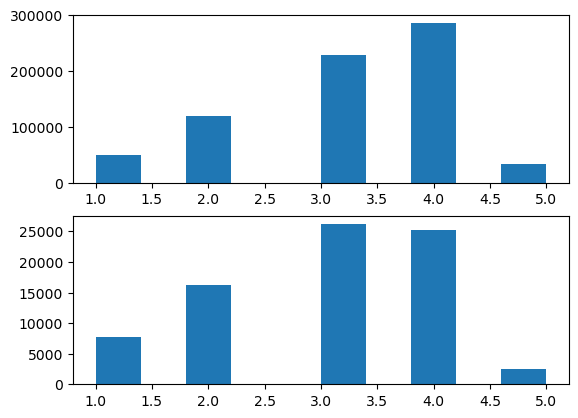

In [108]:
fig1 = plt.figure()

ax1 = fig1.add_subplot(211)
ax1.hist(low_values['ARBEIT'].dropna())
ax2 = fig1.add_subplot(212)
ax2.hist(high_values['ARBEIT'].dropna())

plt.show()

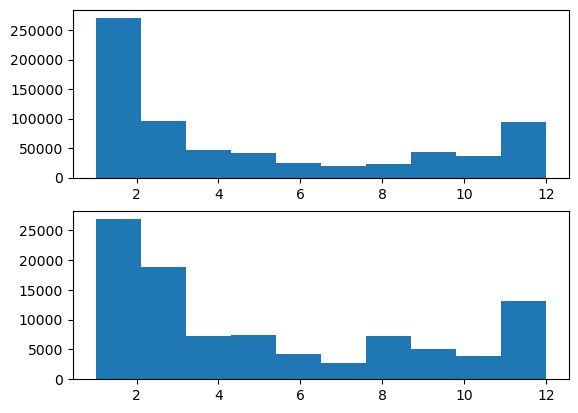

In [109]:
fig1 = plt.figure()

ax1 = fig1.add_subplot(211)
ax1.hist(low_values['LP_LEBENSPHASE_GROB'].dropna())
ax2 = fig1.add_subplot(212)
ax2.hist(high_values['LP_LEBENSPHASE_GROB'].dropna())

plt.show()

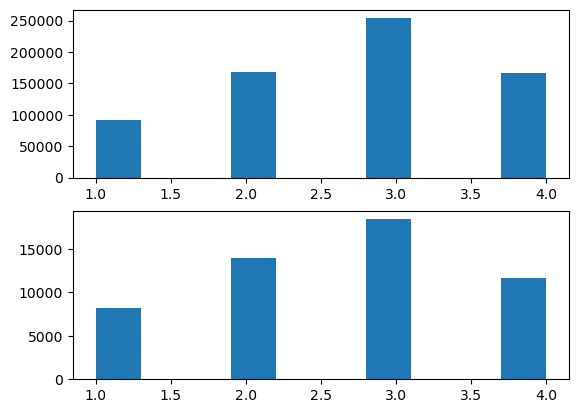

In [110]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(211)
ax1.hist(low_values['KKK'].dropna())
ax2 = fig1.add_subplot(212)
ax2.hist(high_values['KKK'].dropna())
plt.show()

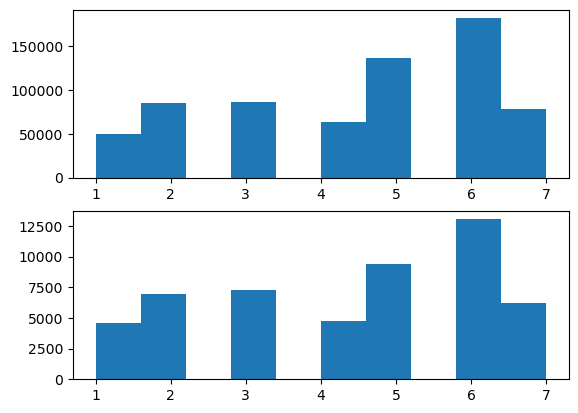

In [111]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(211)
ax1.hist(low_values['REGIOTYP'].dropna())
ax2 = fig1.add_subplot(212)
ax2.hist(high_values['REGIOTYP'].dropna())
plt.show()

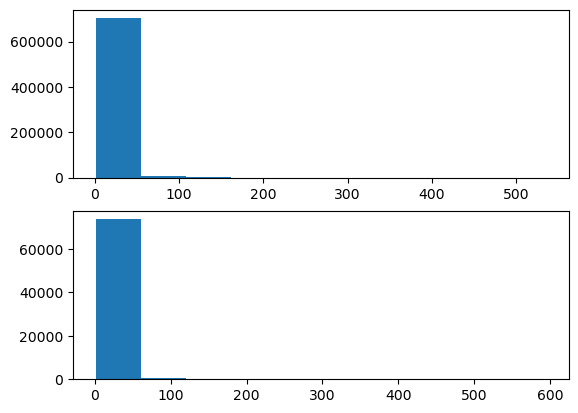

In [112]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(211)
ax1.hist(low_values['ANZ_HAUSHALTE_AKTIV'].dropna())
ax2 = fig1.add_subplot(212)
ax2.hist(high_values['ANZ_HAUSHALTE_AKTIV'].dropna())
plt.show()

#### Discussion 1.1.3: Assess Missing Data in Each Row


The data suggests that the presence of missing values in rows is minimal. Thus, eliminating these rows would have little impact on the overall structure or pattern of the dataset. This observation is reinforced by comparing histograms of features with the least missing data, which demonstrate consistent distributions regardless of the level of missing values.

The criterion used to separate the days was based on the average sum of null values.

### Step 1.2: Select and Re-Encode Features


Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [113]:
# Saving data to save computation 
azdias.to_csv('data-edited.csv', sep=';')

In [114]:
feat_info.head(4)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]


In [115]:
# How many features are there of each data type?
feat_info['type'].value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [116]:
# Assessing categorical variables: which are binary, which are multi-level, and which one needs to be re-encoded?
catagorical_val = feat_info[ feat_info['type'] == 'categorical']

In [117]:
catagorical_val_cols = catagorical_val['attribute'].tolist()

In [118]:
catagorical_val_cols

['AGER_TYP',
 'ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'TITEL_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'KK_KUNDENTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [119]:
type(azdias)

pandas.core.frame.DataFrame

In [120]:
##Find number of classes of catagorical data.

In [121]:
categorical_data = pd.DataFrame(columns=['category', 'number'])
for i in catagorical_val_cols:
    if i in azdias:
        c = {'category': i, 'number': int(azdias[i].nunique()) }
        categorical_data = categorical_data.append(c, ignore_index=True)
        #print(i, azdias[i].nunique())

/var/folders/tk/l8jl358x18q85155m0fs7ldh0000gn/T/ipykernel_76912/3102554155.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  categorical_data = categorical_data.append(c, ignore_index=True)
/var/folders/tk/l8jl358x18q85155m0fs7ldh0000gn/T/ipykernel_76912/3102554155.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  categorical_data = categorical_data.append(c, ignore_index=True)
/var/folders/tk/l8jl358x18q85155m0fs7ldh0000gn/T/ipykernel_76912/3102554155.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  categorical_data = categorical_data.append(c, ignore_index=True)
/var/folders/tk/l8jl358x18q85155m0fs7ldh0000gn/T/ipykernel_76912/3102554155.py:5: FutureWarning: The frame.append method is deprecated and will be removed

In [122]:
categorical_data

,category,number
0,ANREDE_KZ,2
1,CJT_GESAMTTYP,6
2,FINANZTYP,6
3,GFK_URLAUBERTYP,12
4,GREEN_AVANTGARDE,2
5,LP_FAMILIE_FEIN,11
6,LP_FAMILIE_GROB,5
7,LP_STATUS_FEIN,10
8,LP_STATUS_GROB,5
9,NATIONALITAET_KZ,3


In [123]:
categorical_data.columns

Index(['category', 'number'], dtype='object')

In [124]:
categorical_data = categorical_data[categorical_data['number']  > 2]

In [125]:
categorical_data

,category,number
1,CJT_GESAMTTYP,6
2,FINANZTYP,6
3,GFK_URLAUBERTYP,12
5,LP_FAMILIE_FEIN,11
6,LP_FAMILIE_GROB,5
7,LP_STATUS_FEIN,10
8,LP_STATUS_GROB,5
9,NATIONALITAET_KZ,3
10,SHOPPER_TYP,4
13,ZABEOTYP,6


In [126]:
catagorical_val_cols_morethan2 = categorical_data['category']

In [127]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [128]:
catagorical_val_cols_morethan2

1        CJT_GESAMTTYP
2            FINANZTYP
3      GFK_URLAUBERTYP
5      LP_FAMILIE_FEIN
6      LP_FAMILIE_GROB
7       LP_STATUS_FEIN
8       LP_STATUS_GROB
9     NATIONALITAET_KZ
10         SHOPPER_TYP
13            ZABEOTYP
14         GEBAEUDETYP
16     CAMEO_DEUG_2015
17      CAMEO_DEU_2015
Name: category, dtype: object

In [129]:
for i in catagorical_val_cols_morethan2:
    if(i in azdias.columns):
        azdias.drop(columns=i, inplace=True)

In [130]:
mixed_val = feat_info[ feat_info['type'] == 'mixed']

In [131]:
# Mixed Values

In [132]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,3,4,3,5,5,3,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,1,5,2,5,4,5,0,3.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.2.1: Re-Encode Categorical Features

Many categorical variables with more than two features have been predominantly eliminated from the dataset. Given the already extensive dimensions of the data, further augmentation seems impractical at this juncture. However, should the Principal Component Analysis (PCA) fail to achieve satisfactory accuracy or predictive performance in subsequent stages, a reevaluation of this decision may be warranted. This could involve either reintroducing the removed columns through feature engineering or refraining from their elimination altogether.

In [133]:
azdias.to_csv('data-edited-2.csv', sep=';')

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.


In [134]:
mixed_val_col = mixed_val['attribute'].tolist()

In [135]:
azdias= pd.read_csv('data-edited-2.csv', sep=';')

In [136]:
mixed_val = feat_info[ feat_info['type'] == 'mixed']

In [137]:
# Drop remaining mixed values voloums
for i in mixed_val_col:
    if(i in azdias.columns):
        azdias.drop(columns=i, inplace=True)

In [138]:
azdias.to_csv('data-edited-3.csv', sep=';')

In [139]:
azdias= pd.read_csv('data-edited-3.csv', sep=';')

#### Discussion 1.2.2: Engineer Mixed-Type Features

Multi-class categorical variables have been excluded from the dataset to maintain simplicity. Introducing or imputing additional features may enhance accuracy but would necessitate more rigorous tuning efforts. Additionally, specific numeric values have been assigned to the variables CAMEO_INTL_2015 and PRAEGENDE_JUGENDJAHRE.


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

### Step 1.3: Create a Cleaning Function


This cleaning function serves as a comprehensive summary of all the preceding data transformations. It provides a clearer understanding of the code flow. However, it relies on two functions that are defined earlier in the script.

In [140]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # convert missing value codes into NaNs, ...
    print('Starting to clean data..')
    df = covert_Nan(df)
    missingVal = missing_values_table(df)
    outlier =missingVal['% of Total Values'].sort_values(ascending =False)
    # remove selected columns and rows, ...
    outliers = outlier.keys().tolist()
    # Remove the top 6 outliers which have a greater % of total missing values.
    for i in outliers[:6]:
        df.drop(columns=i, inplace=True)
    
    no_of_null_after = df.isnull().sum().sum()
    
    low_values = df[df.isnull().sum(axis = 1) < df.isnull().sum(axis = 1).mean()].copy()
    high_values = df[df.isnull().sum(axis = 1) >= df.isnull().sum(axis = 1).mean()].copy()
    
    low_values1 = missing_values_table(low_values)
    high_values1 = missing_values_table(high_values)
    
    # Note, function assumes feat_info dataframe has already been loaded since its not provided as an input
    catagorical_val = feat_info[ feat_info['type'] == 'categorical']
    # Feature names of categorical variables
    catagorical_val_cols = catagorical_val['attribute'].tolist()
    
    # Select and isolate categorical values to be viewed and possibly re-engineered
    categorical_data = pd.DataFrame(columns=['category', 'number'])
    
    for i in catagorical_val_cols:
        if i in df:
            c = {'category': i, 'number': int(df[i].nunique()) }
            categorical_data = categorical_data.append(c, ignore_index=True)
    
    # Select categorical values with more than 2 labels
    categorical_data = categorical_data[categorical_data['number']  > 2]
    catagorical_val_cols_morethan2 = categorical_data['category']
    
    # drop categorical values with more than two labels
    for i in catagorical_val_cols_morethan2:
        if(i in df.columns):
            df.drop(columns=i, inplace=True)
    
    # Mixed values manipluation starts
    
    # Isolate the values
    mixed_val = feat_info[ feat_info['type'] == 'mixed']
    mixed_val_col = mixed_val['attribute'].tolist()
    
    
    # Re engineer these values
    # create first new varibale: 'MAINSTREAM - YES OR NO'
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([1,3,5,8,10,12,14]),'MAINSTREAM']=1
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([2,4,6,7,9,11,13,15]),'MAINSTREAM']=0
    
    # WESTGERMANY. 
    df.loc[df['OST_WEST_KZ']=='W','WESTGERMANY']=1
    df.loc[df['OST_WEST_KZ']=='O','WESTGERMANY']=0
    
    # I seperated each class and assigned it a value
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([1,2]),'GENERATION']=1
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([3,4]),'GENERATION']=2
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([5,6,7]),'GENERATION']=3
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([8,9]),'GENERATION']=4
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([10,11,12,13]),'GENERATION']=5
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([14,15]),'GENERATION']=6
    
    df.drop('PRAEGENDE_JUGENDJAHRE', axis = 1, inplace=True)
    df.drop('OST_WEST_KZ', axis = 1, inplace=True)
    
    # Investigate "CAMEO_INTL_2015" and engineer new standerdized variables.
    df.loc[df['CAMEO_INTL_2015'].isin(['11','12','13','14','15']),'HOUSEHOLD']=1
    df.loc[df['CAMEO_INTL_2015'].isin(['21','22','23','24','25']),'HOUSEHOLD']=2
    df.loc[df['CAMEO_INTL_2015'].isin(['31','32','33','34','35']),'HOUSEHOLD']=3
    df.loc[df['CAMEO_INTL_2015'].isin(['41','42','43','44','45']),'HOUSEHOLD']=4
    df.loc[df['CAMEO_INTL_2015'].isin(['51','52','53','54','55']),'HOUSEHOLD']=5
    df.loc[df['CAMEO_INTL_2015'].isin(['11','21','31','41','51']),'LIFESTYLE']=1
    df.loc[df['CAMEO_INTL_2015'].isin(['12','22','32','42','52']),'LIFESTYLE']=2
    df.loc[df['CAMEO_INTL_2015'].isin(['13','23','33','43','53']),'LIFESTYLE']=3
    df.loc[df['CAMEO_INTL_2015'].isin(['14','24','34','44','54']),'LIFESTYLE']=4
    df.loc[df['CAMEO_INTL_2015'].isin(['15','25','35','45','55']),'LIFESTYLE']=5
    df.drop('CAMEO_INTL_2015', axis = 1, inplace=True)
    #drop remaining mixed variables
    for i in mixed_val_col:
        if(i in df.columns):
            df.drop(columns=i, inplace=True)
    
    # Return the cleaned dataframe.
    print('Data cleaned!')
    return df

In [141]:
# Technically one can start all over again from here since now the function is ready
azdias3 = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

In [142]:
azdias4 = clean_data(azdias3)

Starting to clean data..


/var/folders/tk/l8jl358x18q85155m0fs7ldh0000gn/T/ipykernel_76912/1869644172.py:3: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for row, feature_col in enumerate(df.iteritems()):
/var/folders/tk/l8jl358x18q85155m0fs7ldh0000gn/T/ipykernel_76912/3114017749.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  categorical_data = categorical_data.append(c, ignore_index=True)
/var/folders/tk/l8jl358x18q85155m0fs7ldh0000gn/T/ipykernel_76912/3114017749.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  categorical_data = categorical_data.append(c, ignore_index=True)
/var/folders/tk/l8jl358x18q85155m0fs7ldh0000gn/T/ipykernel_76912/3114017749.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

Data cleaned!


In [143]:
azdias4.to_csv('azdias4.csv', sep=';')

In [163]:
azdias4 = pd.read_csv('azdias4.csv', delimiter=';')

In [164]:
azdias4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 65 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   888340 non-null  float64
 2   ANREDE_KZ              891221 non-null  int64  
 3   FINANZ_MINIMALIST      891221 non-null  int64  
 4   FINANZ_SPARER          891221 non-null  int64  
 5   FINANZ_VORSORGER       891221 non-null  int64  
 6   FINANZ_ANLEGER         891221 non-null  int64  
 7   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 8   FINANZ_HAUSBAUER       891221 non-null  int64  
 9   GREEN_AVANTGARDE       891221 non-null  int64  
 10  HEALTH_TYP             780025 non-null  float64
 11  RETOURTYP_BK_S         886367 non-null  float64
 12  SEMIO_SOZ              891221 non-null  int64  
 13  SEMIO_FAM              891221 non-null  int64  
 14  SEMIO_REL              891221 non-nu

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.


In [334]:
df = azdias4.copy()

Save categorical feature coloumn and data so that it can be used/referenced later

In [335]:
# Extract all cols names with int type
cat_col_names = df.loc[:, df.dtypes == np.int64].columns
cat_col_names = cat_col_names.tolist()

In [336]:
col_vals =df.columns.tolist()

In [337]:
df_cols = list(set(col_vals) - set(cat_col_names))

In [338]:
df_catogrical_data = df[df_cols]

In [339]:
df_catogrical_data.head(1)

,REGIOTYP,RETOURTYP_BK_S,BALLRAUM,INNENSTADT,VERS_TYP,HOUSEHOLD,GEBAEUDETYP_RASTER,KBA05_ANTG4,PLZ8_ANTG1,ANZ_PERSONEN,...,LIFESTYLE,KBA05_ANTG1,PLZ8_ANTG4,KKK,ORTSGR_KLS9,MOBI_REGIO,RELAT_AB,ANZ_HAUSHALTE_AKTIV,ALTERSKATEGORIE_GROB,PLZ8_ANTG2
0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN


In [340]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd


# Check and drop 'Unnamed: 0' if it exists in df
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)
    

# Separate numeric and categorical columns
numeric_cols = df.select_dtypes(include=['number']).columns
categorical_cols = df.select_dtypes(exclude=['number']).columns

# Pipeline for numeric columns
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),  # Use 'median' strategy for missing values
    ('scaler', StandardScaler())
])

# Pipeline for categorical columns
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent")),  # Use 'most_frequent' strategy for missing values
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # Use one-hot encoding
])

# Column transformer
preprocessor = ColumnTransformer([
    ('numeric', numeric_pipeline, numeric_cols),
    ('categorical', categorical_pipeline, categorical_cols)
])

# Fit and transform the data
df_scaled = preprocessor.fit_transform(df)

# Get column names for numeric columns after transformation
numeric_cols_transformed = preprocessor.transformers_[0][2]

# Fit the OneHotEncoder and get one-hot encoded column names
encoder = preprocessor.named_transformers_['categorical'].named_steps['encoder']
encoder.fit(df[categorical_cols])
one_hot_encoded_cols = encoder.get_feature_names_out(categorical_cols)

# Concatenate column names
new_columns = list(numeric_cols_transformed) + list(one_hot_encoded_cols)

# Convert the transformed data to DataFrame
df_scaled = pd.DataFrame(df_scaled, columns=new_columns)


In [341]:
df_scaled.isnull().sum().sum()

0

In [342]:
df_scaled.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,MAINSTREAM,WESTGERMANY,GENERATION,HOUSEHOLD,LIFESTYLE
count,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,...,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05
mean,2.500235e-17,1.004638e-16,3.507983e-18,9.879756e-17,5.941247e-17,-3.310260e-17,3.897050e-17,1.505562e-16,9.583171e-18,-5.471656e-17,...,9.532146e-17,1.080140e-16,-6.572684e-17,5.084582e-17,1.161940e-16,-1.131962e-16,-3.138050e-17,2.686796e-16,5.176667e-17,-1.251712e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.743339e+00,-1.045218e+00,-1.570358e+00,-1.243244e+00,-1.816084e+00,-1.329319e+00,-1.260597e+00,-1.533438e+00,-4.947009e-01,-1.644405e+00,...,-2.903238e+00,-2.232324e+00,-2.275090e+00,-1.958378e+00,-1.606600e+00,-2.021423e+00,-2.070684e+00,-2.399409e+00,-1.674720e+00,-1.347861e+00
25%,-7.516797e-01,-1.045218e+00,-8.133868e-01,-1.243244e+00,-3.033778e-01,-6.755539e-01,-5.879796e-01,-7.944745e-01,-4.947009e-01,-2.346007e-01,...,-7.231711e-01,-3.172055e-01,-1.572239e-01,-5.796808e-01,-8.279336e-01,4.947009e-01,4.829322e-01,-2.131019e-01,-9.603583e-01,-1.347861e+00
50%,2.399800e-01,9.567382e-01,-5.641562e-02,1.221788e-01,-3.033778e-01,-2.178896e-02,8.463740e-02,-5.551131e-02,-4.947009e-01,-2.346007e-01,...,3.668625e-01,-3.172055e-01,-1.572239e-01,-1.201149e-01,-4.926747e-02,4.947009e-01,4.829322e-01,-2.131019e-01,4.683658e-01,8.057268e-02
75%,1.231640e+00,9.567382e-01,7.005556e-01,8.048901e-01,1.209329e+00,1.285741e+00,7.572544e-01,6.834519e-01,-4.947009e-01,1.175204e+00,...,3.668625e-01,6.403537e-01,9.017093e-01,7.990167e-01,7.293987e-01,4.947009e-01,4.829322e-01,1.244436e+00,1.182728e+00,7.947894e-01
max,1.231640e+00,9.567382e-01,1.457527e+00,1.487601e+00,1.209329e+00,1.285741e+00,1.429871e+00,1.422415e+00,2.021423e+00,1.175204e+00,...,1.456896e+00,1.597913e+00,1.960642e+00,1.718148e+00,1.508065e+00,4.947009e-01,4.829322e-01,1.244436e+00,1.182728e+00,1.509006e+00


In [343]:
df_scaled.dtypes[df_scaled.dtypes == "Object"]

Series([], dtype: object)

### Discussion 2.1: Apply Feature Scaling

I extracted the categorical features and stored them in a variable. Subsequently, I standardized, scaled, and transformed these features into continuous variables to optimize PCA evaluation and prediction. After obtaining the predicted output variable, I will reintegrate the saved categorical variables, removing any scaled categorical values that may have been converted to continuous. This process is essential for the appropriate analysis of the data.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [344]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

In [345]:

def pca_results(full_dataset, pca):
	'''
	Create a DataFrame of the PCA results
	Includes dimension feature weights and explained variance
	Visualizes the PCA results
	'''

	# Dimension indexing
	dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

	# PCA components
	components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
	components.index = dimensions

	# PCA explained variance
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions

	# Create a bar plot visualization
	fig, ax = plt.subplots(figsize = (16,8))

	# Plot the feature weights as a function of the components
	components.plot(ax = ax, kind = 'bar');
	ax.set_ylabel("Feature Weights")
	ax.set_xticklabels(dimensions, rotation=0)


	# Display the explained variance ratios
	for i, ev in enumerate(pca.explained_variance_ratio_):
		ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

	# Return a concatenated DataFrame
	return pd.concat([variance_ratios, components], axis = 1)

,Explained Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,MAINSTREAM,WESTGERMANY,GENERATION,HOUSEHOLD,LIFESTYLE
count,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,...,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000
mean,0.015876,-0.001959,-0.009057,-0.016567,-0.010976,0.010411,0.010662,-0.005046,-0.000754,0.007619,...,-0.010359,-0.000302,0.019121,0.033656,-0.017313,-0.007619,-0.013346,-0.004689,-0.007589,-0.020129
std,0.028022,0.126981,0.126669,0.125895,0.126521,0.126567,0.126548,0.126903,0.126997,0.089477,...,0.126567,0.126993,0.125527,0.122389,0.125791,0.089477,0.126282,0.126909,0.126770,0.125367
min,0.001200,-0.392700,-0.625500,-0.466800,-0.750100,-0.332700,-0.255600,-0.421100,-0.411800,-0.316600,...,-0.494600,-0.378900,-0.312900,-0.219800,-0.422700,-0.404700,-0.449400,-0.423300,-0.625200,-0.416500
25%,0.003150,-0.055350,-0.031850,-0.078900,-0.041450,-0.073950,-0.055600,-0.078500,-0.072600,-0.020650,...,-0.039300,-0.039400,-0.044150,-0.026800,-0.053650,-0.027700,-0.070700,-0.052400,-0.061550,-0.040750
50%,0.006600,-0.004400,0.006100,0.005900,-0.003200,0.000300,0.019700,-0.000600,0.008100,0.002800,...,0.006000,-0.000900,0.017600,0.039200,-0.001500,-0.002800,-0.000500,-0.011100,0.006100,0.000700
75%,0.015950,0.051150,0.050700,0.067950,0.047450,0.087850,0.080950,0.083400,0.087000,0.027700,...,0.052350,0.037850,0.068900,0.081700,0.055900,0.020650,0.069100,0.049300,0.036650,0.026800
max,0.164500,0.388800,0.257400,0.250300,0.182500,0.436100,0.257800,0.302900,0.303800,0.404700,...,0.233000,0.690000,0.559000,0.496600,0.215600,0.316600,0.238400,0.411100,0.212700,0.394800


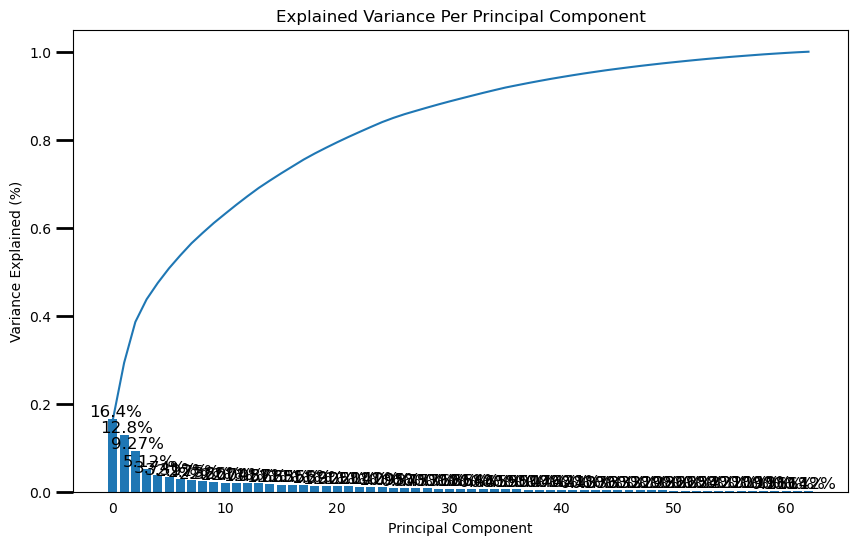

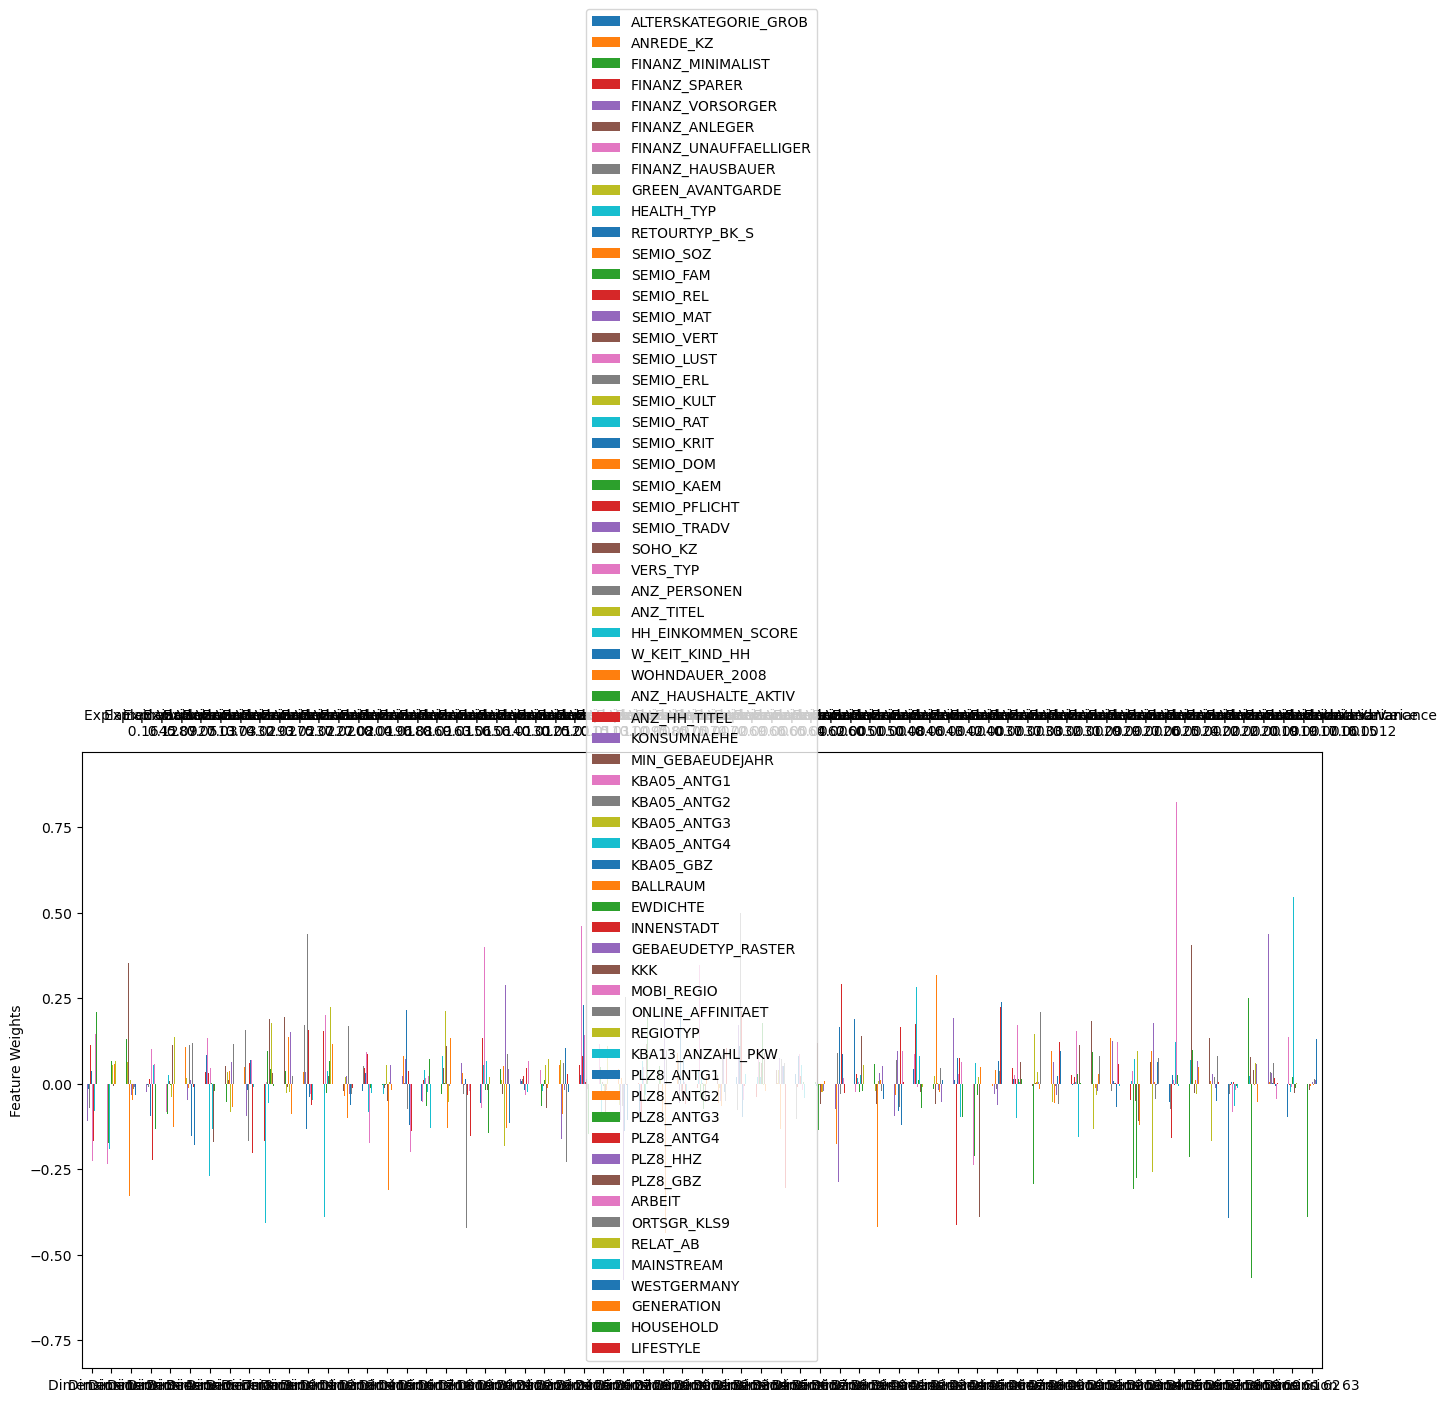

In [346]:
pca = PCA(63)
df_pca = pca.fit_transform(df_scaled)
scree_plot(pca)
pca_results(df_scaled,pca).describe()

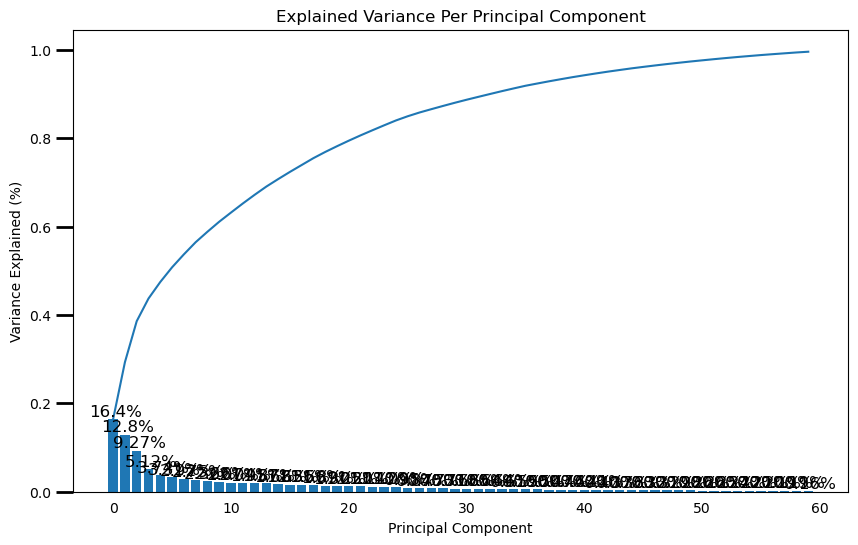

In [347]:
pca = PCA(60)
df_pca = pca.fit_transform(df_scaled)
scree_plot(pca)

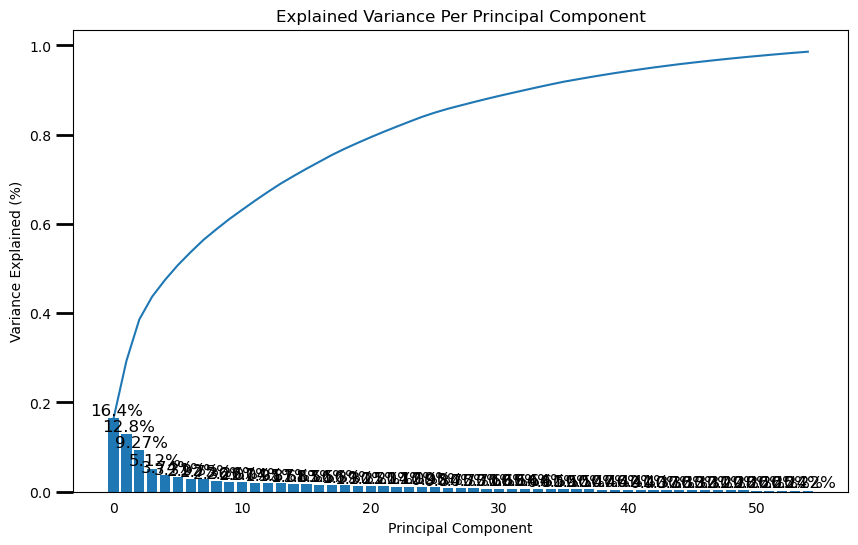

In [348]:
pca = PCA(55)
df_pca = pca.fit_transform(df_scaled)
scree_plot(pca)

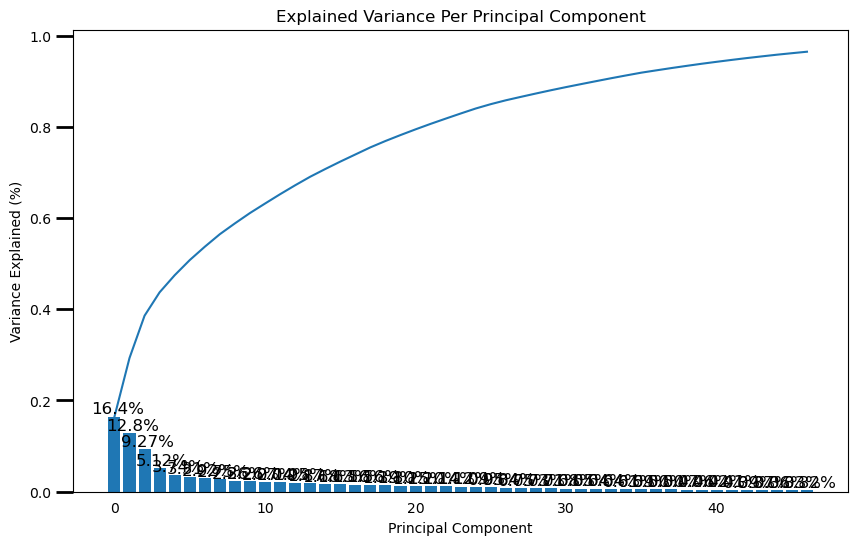

In [349]:
pca = PCA(47)
df_pca = pca.fit_transform(df_scaled)
scree_plot(pca)

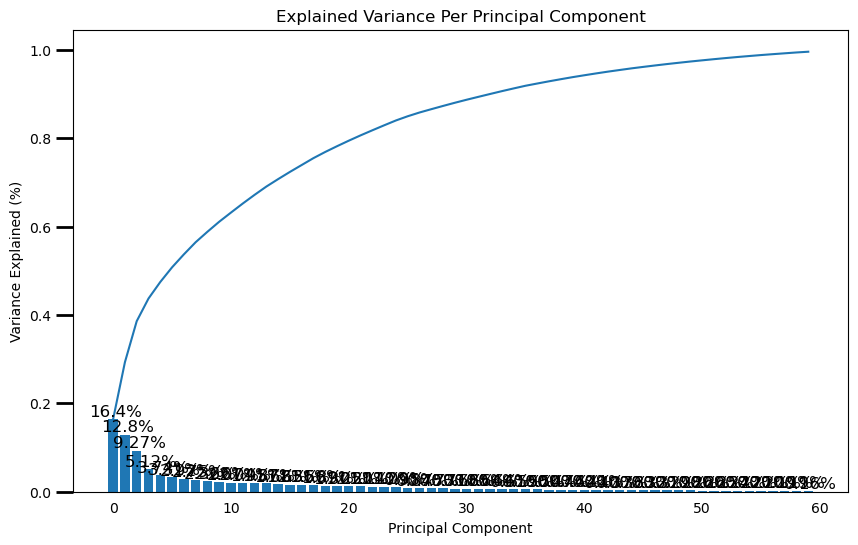

In [350]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(60)
df_pca = pca.fit_transform(df_scaled)
scree_plot(pca)

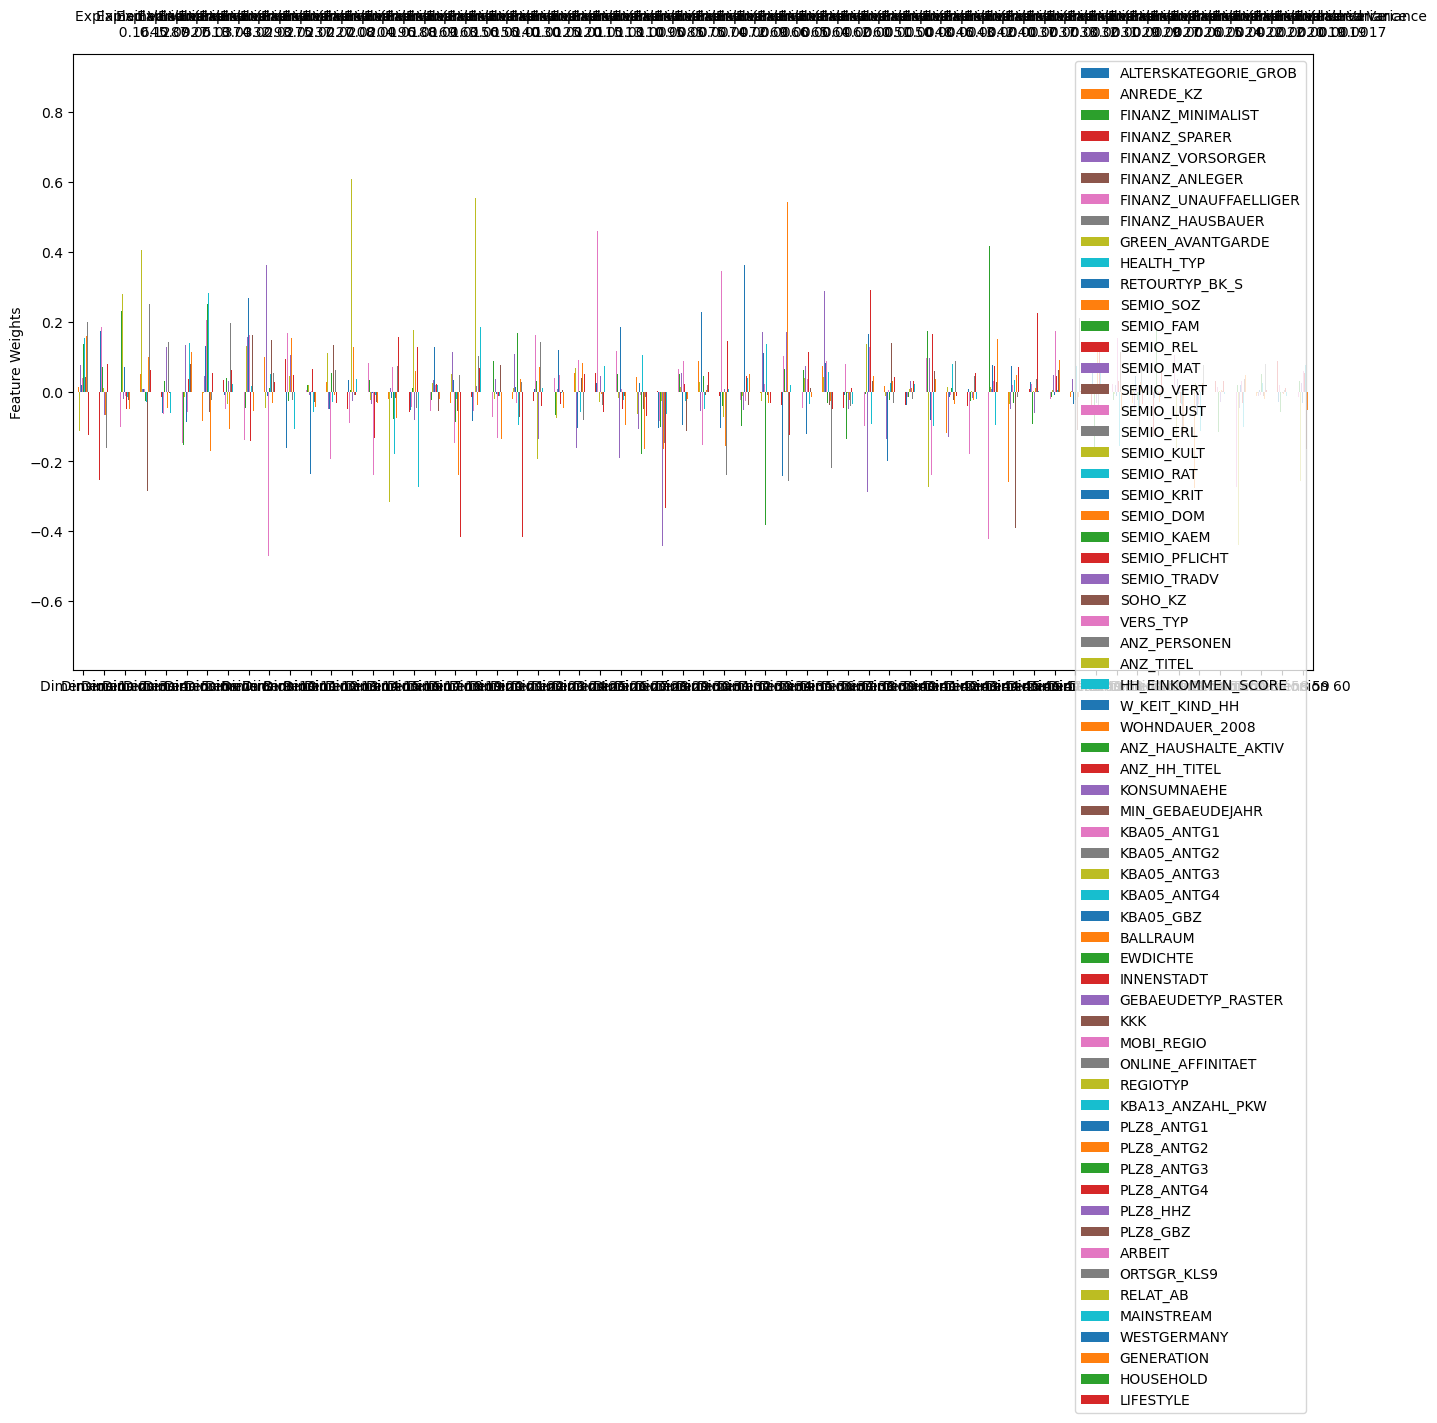

In [351]:
components = pca_results(df_scaled,pca)

In [352]:
components.head(12)

,Explained Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,MAINSTREAM,WESTGERMANY,GENERATION,HOUSEHOLD,LIFESTYLE
Dimension 1,0.1645,-0.1126,0.0135,-0.2175,0.1428,-0.1102,0.0704,0.0739,0.1619,-0.1119,...,0.0454,-0.1722,0.1447,0.2007,0.1380,0.1119,-0.0493,0.0919,0.2104,-0.1252
Dimension 2,0.1287,0.2684,0.0601,0.0825,-0.2522,0.2477,-0.2228,-0.2344,0.1140,-0.0004,...,0.0055,-0.0647,0.0704,0.0927,0.0658,0.0004,-0.0336,-0.2595,0.0635,0.0026
Dimension 3,0.0927,0.0430,-0.3573,0.1295,-0.0847,0.0648,-0.1805,-0.1017,-0.0461,0.0630,...,-0.0097,-0.0251,0.0394,0.0489,0.0308,-0.0630,-0.0342,-0.0508,0.0089,-0.0173
Dimension 4,0.0513,-0.0462,0.0492,0.0545,-0.0032,-0.0237,-0.1170,0.0605,-0.1009,0.4047,...,0.1335,0.0434,0.0573,0.2496,0.0957,-0.4047,0.0969,0.0521,-0.1327,0.0607
Dimension 5,0.0374,-0.0044,0.0430,0.0504,-0.0141,-0.0740,0.0140,-0.0841,-0.0637,0.0621,...,-0.4946,-0.3789,0.2163,0.0829,0.1355,-0.0621,-0.2451,0.0660,-0.0251,0.0235
Dimension 6,0.0332,-0.0103,0.1065,-0.1403,-0.0166,-0.0553,-0.0506,-0.1476,0.1123,0.0166,...,0.0344,0.0794,-0.1161,-0.0788,-0.1773,-0.0166,-0.1795,0.1123,-0.0876,0.0235
Dimension 7,0.0293,-0.0126,-0.0846,0.0925,0.0328,0.0211,0.0729,0.1364,-0.0656,-0.0040,...,-0.0699,-0.1713,-0.1672,-0.0242,-0.1326,0.0040,0.0778,-0.1028,-0.0215,0.0541
Dimension 8,0.0275,0.0413,-0.0435,0.0682,0.0332,-0.0123,0.0524,0.0218,-0.2030,-0.0216,...,0.2330,0.1299,0.0204,0.1151,0.0243,0.0216,0.0998,0.0987,0.0152,-0.0797
Dimension 9,0.0237,-0.1604,0.0478,-0.0672,-0.0658,0.1007,-0.1026,-0.1393,0.1577,0.0107,...,-0.0448,0.1609,0.1301,0.1459,0.1043,-0.0107,0.0786,-0.0548,-0.0847,0.0823
Dimension 10,0.0227,-0.0282,0.0993,0.1365,-0.1676,0.1151,-0.1047,-0.0953,-0.0554,-0.0471,...,0.1087,0.0308,0.0740,0.0528,0.0285,0.0471,-0.0311,-0.1632,-0.0057,0.0287


### Discussion 2.2: Perform Dimensionality Reduction

Considering that I've already limited the number of dimensions by not incorporating additional categorical features in the raw data, and observing the curve above which steadily converges and tapers towards 1.0 with a relatively narrow margin, it suggests that making drastic changes to the number of features is unnecessary.

Although reducing features may not substantially impact variance, I am inclined to maintain the current 60 features rather than further reducing them to ensure favorable outcomes. The minimal impact on time and resource complexity justifies this decision for such marginal changes in this scenario.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [353]:
type(components)

pandas.core.frame.DataFrame

In [354]:
# Map weights for the first principal component to corresponding feature names and then print the linked values, sorted by weight.

def get_weights(df, number):
    #input components dataframe
    # Outuput Series
    cmp_num = 'Dimension ' +str(number);
    #print(cmp_num)
    cmp = df.T[cmp_num].sort_values(ascending=False)
    return cmp
    

pc_1 = get_weights(components, 1)
pc_2 = get_weights(components, 2)
pc_3 = get_weights(components, 3)

In [355]:
type(pc_1)

pandas.core.series.Series

In [356]:
pc_1

PLZ8_ANTG3           0.2318
PLZ8_ANTG4           0.2249
HOUSEHOLD            0.2104
ORTSGR_KLS9          0.2007
EWDICHTE             0.2006
                      ...  
FINANZ_MINIMALIST   -0.2175
KBA05_GBZ           -0.2205
KBA05_ANTG1         -0.2271
PLZ8_ANTG1          -0.2316
MOBI_REGIO          -0.2455
Name: Dimension 1, Length: 65, dtype: float64

### Discussion 2.3: Interpret Principal Components
Map the weights for the second principal component to their respective feature names and display the associated values, sorted by weight.

Top 7
PLZ8_ANTG3            0.2318
PLZ8_ANTG4            0.2249
HOUSEHOLD             0.2104
ORTSGR_KLS9           0.2007
EWDICHTE              0.2006
HH_EINKOMMEN_SCORE    0.1737
Explained Variance    0.1645
Name: Dimension 1, dtype: float64
-----------------------------
Bottom 7
KONSUMNAEHE         -0.1700
PLZ8_GBZ            -0.1722
FINANZ_MINIMALIST   -0.2175
KBA05_GBZ           -0.2205
KBA05_ANTG1         -0.2271
PLZ8_ANTG1          -0.2316
MOBI_REGIO          -0.2455
Name: Dimension 1, dtype: float64


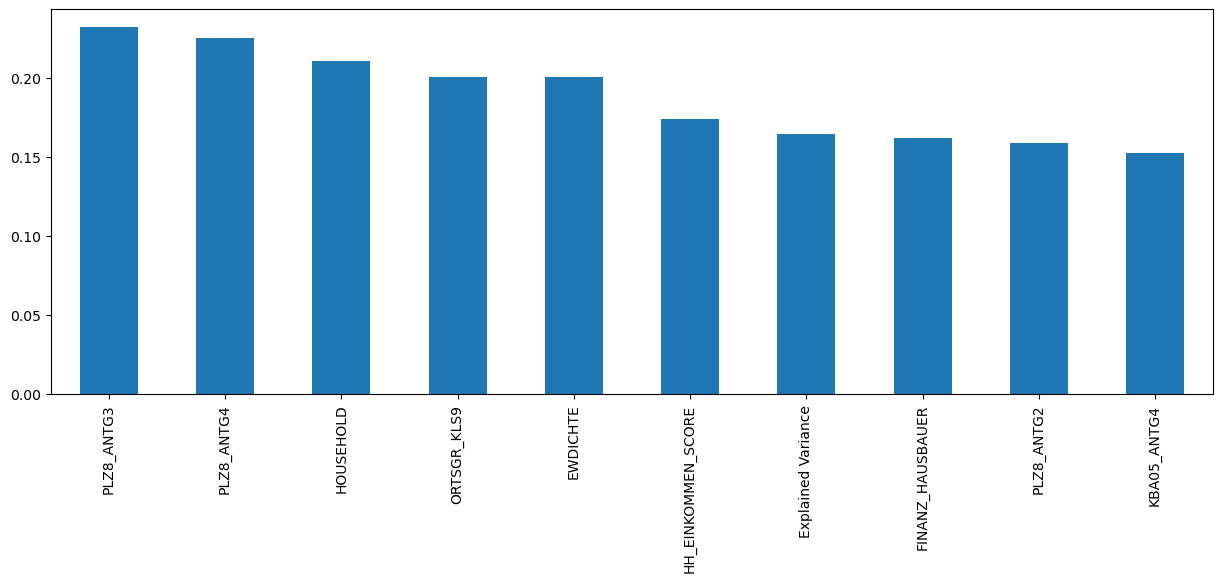

In [357]:
print('Top 7')
print(pc_1[:7])
print('-----------------------------')
print('Bottom 7')
print(pc_1.tail(7))

pc_1[:10].plot.bar(figsize=(15,5));

Top 7
ALTERSKATEGORIE_GROB    0.2684
FINANZ_VORSORGER        0.2477
SEMIO_ERL               0.2249
SEMIO_LUST              0.1858
RETOURTYP_BK_S          0.1725
Explained Variance      0.1287
W_KEIT_KIND_HH          0.1275
Name: Dimension 2, dtype: float64
-----------------------------
Bottom 7
FINANZ_ANLEGER          -0.2228
SEMIO_TRADV             -0.2344
FINANZ_UNAUFFAELLIGER   -0.2344
SEMIO_PFLICHT           -0.2413
SEMIO_REL               -0.2491
FINANZ_SPARER           -0.2522
GENERATION              -0.2595
Name: Dimension 2, dtype: float64


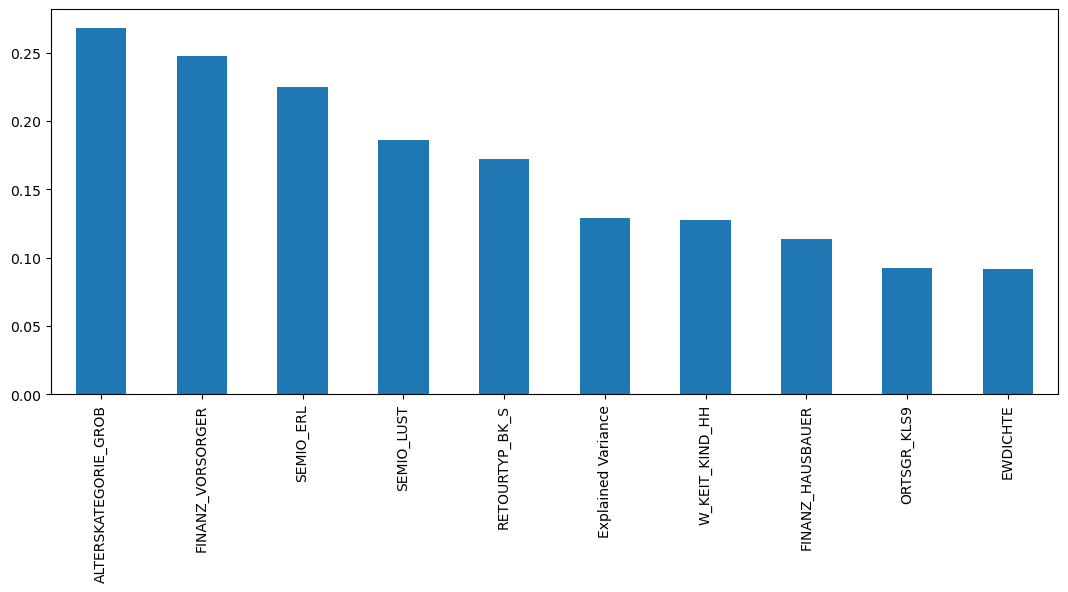

In [358]:
print('Top 7')
print(pc_2[:7])
print('-----------------------------')
print('Bottom 7')
print(pc_2.tail(7))

pc_2[:10].plot.bar(figsize=(13,5));

Top 7
SEMIO_VERT            0.3537
SEMIO_SOZ             0.2913
SEMIO_KULT            0.2790
SEMIO_FAM             0.2316
FINANZ_MINIMALIST     0.1295
Explained Variance    0.0927
RETOURTYP_BK_S        0.0818
Name: Dimension 3, dtype: float64
-----------------------------
Bottom 7
SEMIO_ERL        -0.1770
FINANZ_ANLEGER   -0.1805
SEMIO_RAT        -0.1805
SEMIO_KRIT       -0.3076
SEMIO_DOM        -0.3295
SEMIO_KAEM       -0.3561
ANREDE_KZ        -0.3573
Name: Dimension 3, dtype: float64


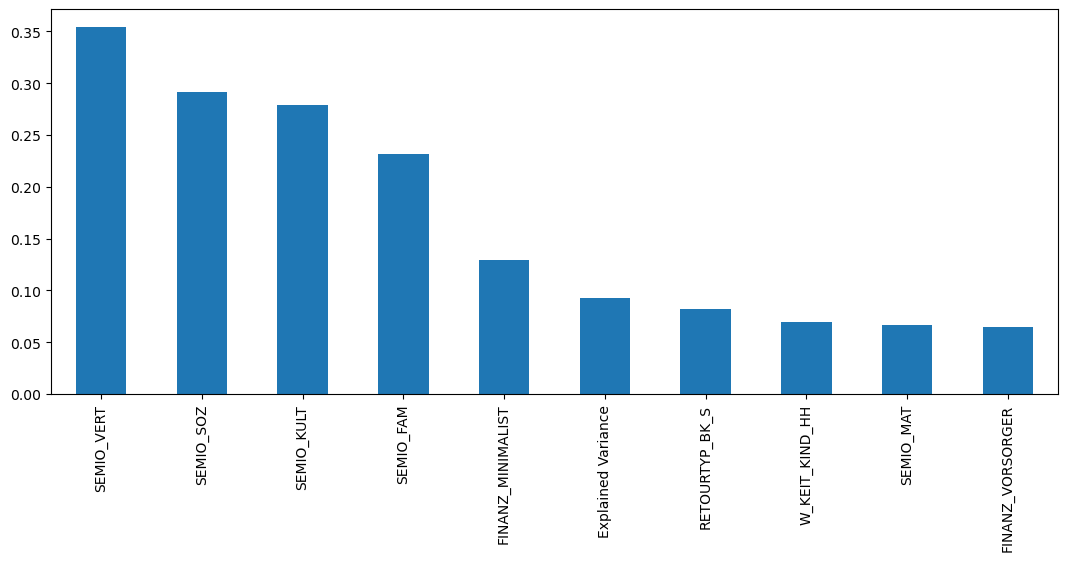

In [359]:
print('Top 7')
print(pc_3[:7])
print('-----------------------------')
print('Bottom 7')
print(pc_3.tail(7))

pc_3[:10].plot.bar(figsize=(13,5));

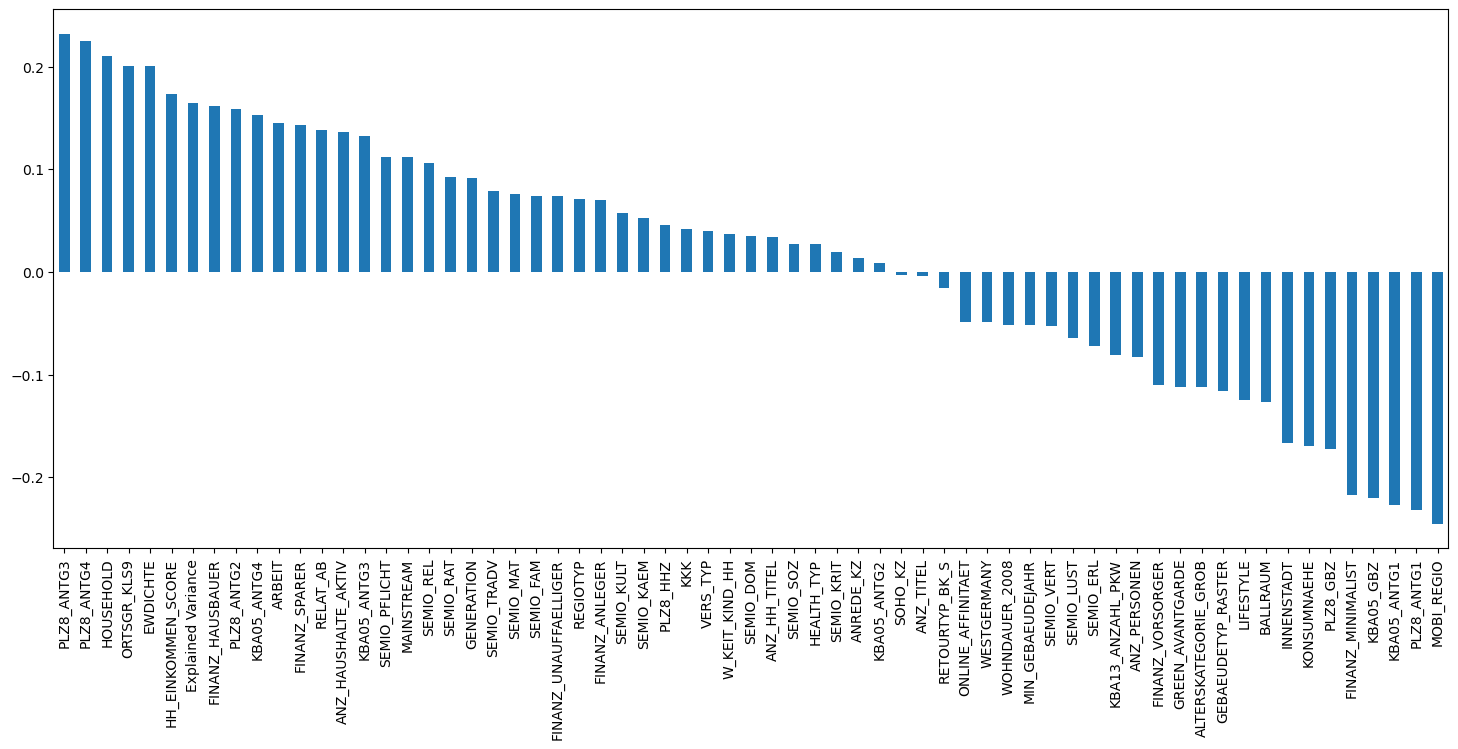

In [360]:
pc_1.plot.bar(figsize=(18,7));

In [361]:
# Find the most comman features which appears in all the three components. Top values and low values 
from functools import reduce
topvals = reduce(np.intersect1d, (pc_1[:25].keys(), pc_2[:30].keys(), pc_3[:30].keys()))
lowvals = reduce(np.intersect1d, (pc_1.tail(19).keys(), pc_2.tail(30).keys(), pc_3.tail(35).keys()))
print('Top values in all 3 comp.:', topvals)
print('Lowest values in all 3 comp.:', lowvals.tolist())



Top values in all 3 comp.: ['ANZ_HAUSHALTE_AKTIV' 'ARBEIT' 'EWDICHTE' 'Explained Variance'
 'HH_EINKOMMEN_SCORE' 'HOUSEHOLD' 'KBA05_ANTG3' 'KBA05_ANTG4'
 'ORTSGR_KLS9' 'PLZ8_ANTG2' 'PLZ8_ANTG3' 'PLZ8_ANTG4' 'RELAT_AB']
Lowest values in all 3 comp.: ['BALLRAUM', 'GEBAEUDETYP_RASTER', 'INNENSTADT', 'KBA05_ANTG1', 'KBA05_GBZ', 'KBA13_ANZAHL_PKW', 'KONSUMNAEHE', 'MOBI_REGIO', 'PLZ8_ANTG1', 'PLZ8_GBZ']


#### Top Values across all 3 components
- EWDICHTE: Household density per square kilometer
- KBA05_ANTG4: Number of 10+ family houses in the microcell
- ORTSGR_KLS9: Size of the community

#### Lowest Values across all 3 components
- KONSUMNAEHE: Distance from building to point of sale (PoS)
- MOBI_REGIO: Movement patterns
- PLZ8_ANTG1: Number of 1-2 family houses in the PLZ8 region

In [362]:
print('--------------------------------------------')
print('Component 1:')
print('--------------------------------------------')
print('Top',pc_1.head(4))
print('--------------------------------------------')
print('Low',pc_1.tail(4))
print('--------------------------------------------')
print('Component 2:')
print('--------------------------------------------')
print('Top',pc_2.head(4))
print('--------------------------------------------')
print('Low',pc_2.tail(4))
print('--------------------------------------------')
print('Component 3:')
print('--------------------------------------------')
print('Top',pc_3.head(4))
print('--------------------------------------------')
print('Low',pc_3.tail(4))
print('--------------------------------------------')

--------------------------------------------
Component 1:
--------------------------------------------
Top PLZ8_ANTG3     0.2318
PLZ8_ANTG4     0.2249
HOUSEHOLD      0.2104
ORTSGR_KLS9    0.2007
Name: Dimension 1, dtype: float64
--------------------------------------------
Low KBA05_GBZ     -0.2205
KBA05_ANTG1   -0.2271
PLZ8_ANTG1    -0.2316
MOBI_REGIO    -0.2455
Name: Dimension 1, dtype: float64
--------------------------------------------
Component 2:
--------------------------------------------
Top ALTERSKATEGORIE_GROB    0.2684
FINANZ_VORSORGER        0.2477
SEMIO_ERL               0.2249
SEMIO_LUST              0.1858
Name: Dimension 2, dtype: float64
--------------------------------------------
Low SEMIO_PFLICHT   -0.2413
SEMIO_REL       -0.2491
FINANZ_SPARER   -0.2522
GENERATION      -0.2595
Name: Dimension 2, dtype: float64
--------------------------------------------
Component 3:
--------------------------------------------
Top SEMIO_VERT    0.3537
SEMIO_SOZ     0.2913
SEMIO_K

### First Component Analysis
Top:
- PLZ8_ANTG3: Number of 6-10 family houses in the PLZ8 region
- PLZ8_ANTG4: Number of 10+ family houses in the PLZ8 region
Low:
- MOBI_REGIO: Movement patterns
- PLZ8_ANTG1: Number of 1-2 family houses in the PLZ8 region

### Second Component Analysis
Top:
- ALTERSKATEGORIE_GROB: Estimated age based on given name analysis
- FINANZ_VORSORGER: Financial typology, Be prepared
Low:
- GENERATION: Age differences according to 10 years 70, 80, 90
- FINANZ_SPARER: Financial typology, money-saver

### Third Component Analysis
Top:
- SEMIO_VERT: Personality typology, dreamful
- SEMIO_SOZ: Personality typology, Social Minded
Low:
- ANREDE_KZ: Gender
- SEMIO_KAEM: Personality typology, combative attitude

### Collective Component Analysis
#### Top
Collectively, top values highlight factors related to housing, neighborhood, and demographic characteristics. These include density of households, number of large family houses, community size, and age demographics. These indicators reflect the geographical, societal, and social aspects of the locality.

#### Low
Conversely, the lowest values suggest correlations with distance, movement patterns, gender, and generational differences.

<hr>

### Component-wise Analysis
#### First Component
- Top Values: Indicate a positive correlation with the number of large family houses in the region, suggesting a communal environment.
- Low Values: Reflect individualistic tendencies, evident from movement patterns and fewer family houses with low occupants.

#### Second Component
- Top Values: Associated with age and financial responsibility, indicating proactive financial behavior.
- Low Values: Show generational differences and a focus on saving money.

#### Third Component
- Top Values: Reflect personalities characterized as dreamful and socially minded.
- Low Values: Highlight gender-related issues and a combative attitude.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.


In [363]:
df_pca.view()

array([[ 9.95408997e-01, -1.11138582e+00, -1.66884525e+00, ...,
        -2.68355601e-02,  8.23200268e-01, -3.69880844e-01],
       [ 3.93462925e+00, -2.85726045e+00, -2.20097912e+00, ...,
        -1.43494802e-03,  6.80741520e-02,  5.63903384e-01],
       [-1.04545738e+00,  9.65812909e-02, -2.66468540e+00, ...,
        -8.20021384e-01,  3.33278221e-01, -2.40598480e-01],
       ...,
       [-1.20392789e+00, -3.49909112e+00, -2.19859130e+00, ...,
         2.78769478e-02, -1.27662609e-01, -6.39147162e-02],
       [ 5.89802829e+00, -3.00650139e+00,  2.89534748e+00, ...,
         4.69542897e-01,  1.69917783e-01,  5.29458042e-01],
       [-9.53005723e-01,  1.59982884e+00,  3.14841719e+00, ...,
        -3.37578173e-01, -5.36106215e-01,  2.95166799e-01]])

In [364]:
# Shorten the dataset so fast
data = df_pca[3:2010]

In [365]:
arr = pd.Series(range(2, 28))

In [366]:
scoress = []
for i in arr:
    #print(i)
    kmeans_model = KMeans(i)
    model_k = kmeans_model.fit(data)
    val = model_k.score(data,i)
    scoress.append(abs(val))

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 1

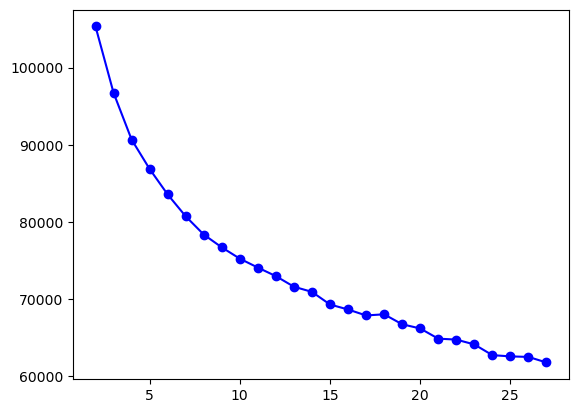

In [367]:
#  average point-centroid distances are the errors which are being reported through this plot
plt.plot(arr, scoress, linestyle='-', marker='o', color='b')

### Number of clusters

The elbow curve indicates a noticeable bend around the range of 9-13. The abrupt change in gradient occurs at k = 9, suggesting it as the optimal choice.

In [368]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
k = 11
final_kmeans_model = KMeans(k)
f_model_k = final_kmeans_model.fit(df_pca)
predictions = f_model_k.predict(df_pca)
print(predictions)

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[ 3  0  2 ...  5  7 10]


In [369]:
# to have backup incase corrupt 
tempvar = predictions.copy()

In [370]:
pd.DataFrame(predictions).to_csv('predictions.csv')

In [371]:
# This variable is the list of labels for the greater population dataset
predictions = pd.read_csv('predictions.csv', header=None)
s = predictions[predictions.columns[1]]
predictions = s.values
predictions

array([ 0,  3,  0, ...,  5,  7, 10])

### Discussion 3.1: Apply Clustering to General Population

The population will be partitioned into K clusters. The elbow curve indicates a noticeable bend, suggesting a shift in gradient around the range of 9-13. At k = 9, this change appears most pronounced, making it a suitable choice for K. Detailed discussions on significant class variables have been provided earlier for individual consideration.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.


In [427]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [428]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_df = clean_data(customers)

Starting to clean data..


/var/folders/tk/l8jl358x18q85155m0fs7ldh0000gn/T/ipykernel_76912/1869644172.py:3: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for row, feature_col in enumerate(df.iteritems()):


/var/folders/tk/l8jl358x18q85155m0fs7ldh0000gn/T/ipykernel_76912/3114017749.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  categorical_data = categorical_data.append(c, ignore_index=True)
/var/folders/tk/l8jl358x18q85155m0fs7ldh0000gn/T/ipykernel_76912/3114017749.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  categorical_data = categorical_data.append(c, ignore_index=True)
/var/folders/tk/l8jl358x18q85155m0fs7ldh0000gn/T/ipykernel_76912/3114017749.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  categorical_data = categorical_data.append(c, ignore_index=True)
/var/folders/tk/l8jl358x18q85155m0fs7ldh0000gn/T/ipykernel_76912/3114017749.py:39: FutureWarning: The frame.append method is deprecated and will be rem

Data cleaned!


In [429]:
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 64 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ALTERSKATEGORIE_GROB   191412 non-null  float64
 1   ANREDE_KZ              191652 non-null  int64  
 2   FINANZ_MINIMALIST      191652 non-null  int64  
 3   FINANZ_SPARER          191652 non-null  int64  
 4   FINANZ_VORSORGER       191652 non-null  int64  
 5   FINANZ_ANLEGER         191652 non-null  int64  
 6   FINANZ_UNAUFFAELLIGER  191652 non-null  int64  
 7   FINANZ_HAUSBAUER       191652 non-null  int64  
 8   GREEN_AVANTGARDE       191652 non-null  int64  
 9   HEALTH_TYP             142662 non-null  float64
 10  RETOURTYP_BK_S         188439 non-null  float64
 11  SEMIO_SOZ              191652 non-null  int64  
 12  SEMIO_FAM              191652 non-null  int64  
 13  SEMIO_REL              191652 non-null  int64  
 14  SEMIO_MAT              191652 non-nu

In [430]:
#Save categorical values
customers_df_catagcol_names = customers_df.loc[:, customers_df.dtypes == np.int64].columns
customers_df_catagcol_names = customers_df_catagcol_names.tolist()
len(customers_df_catagcol_names)

22

In [431]:
# Coloums to retain their original shape so that information can be gleaned later on
add_colms = {'HOUSEHOLD', 'LIFESTYLE', 'GENERATION','MAINSTREAM','WESTGERMANY'}
customers_df_catagcol_names.extend(add_colms)

In [432]:
len(customers_df_catagcol_names)
customers_df_catagcol_names

['ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'GREEN_AVANTGARDE',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'MAINSTREAM',
 'WESTGERMANY',
 'LIFESTYLE',
 'HOUSEHOLD',
 'GENERATION']

In [433]:
customer_df_cols = customers_df.columns.tolist()


In [434]:
customer_df_cols_edited = list(set(customer_df_cols) - set(customers_df_catagcol_names))
customer_df_catogrical_data = customers_df[customers_df_catagcol_names]
#customer_df_catogrical_data.info()

In [435]:
customer_df_catogrical_data.head(12)

,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,SEMIO_SOZ,SEMIO_FAM,...,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,MAINSTREAM,WESTGERMANY,LIFESTYLE,HOUSEHOLD,GENERATION
0,1,5,1,5,1,2,2,1,6,5,...,3,1,1,2,1,0.0,1.0,3.0,1.0,2.0
1,1,5,1,5,1,3,2,0,3,6,...,3,3,2,4,1,NaN,NaN,NaN,NaN,NaN
2,2,5,1,5,1,4,4,1,2,2,...,7,5,6,4,1,0.0,1.0,4.0,3.0,2.0
3,1,5,1,5,2,1,2,0,6,5,...,3,3,3,3,4,1.0,1.0,4.0,2.0,1.0
4,1,3,1,4,4,5,2,0,4,5,...,3,5,2,5,4,1.0,1.0,1.0,4.0,4.0
5,1,5,1,5,1,2,3,1,6,4,...,5,5,3,3,4,0.0,1.0,4.0,3.0,2.0
6,1,5,1,5,1,1,2,1,4,2,...,3,1,2,2,4,0.0,1.0,3.0,2.0,2.0
7,1,5,1,5,1,2,2,1,6,4,...,3,3,1,1,1,0.0,1.0,5.0,1.0,2.0
8,2,2,2,5,1,1,5,0,2,3,...,7,6,6,1,1,1.0,1.0,5.0,5.0,1.0
9,1,5,2,4,1,3,1,1,6,4,...,3,5,3,3,4,0.0,1.0,5.0,1.0,4.0


In [436]:
# Check and drop 'Unnamed: 0' if it exists in customers_df
if 'Unnamed: 0' in customers_df.columns:
    customers_df.drop(columns=['Unnamed: 0'], inplace=True)

# 
# Separate numeric and categorical columns for customers_df
numeric_cols = customers_df.select_dtypes(include=['number']).columns
categorical_cols = customers_df.select_dtypes(exclude=['number']).columns

# Transform the data using the already fitted 'preprocessor'
customers_df_scaled = preprocessor.transform(customers_df)

# 'numeric_cols_transformed' is not needed since 'preprocessor.transformers_[0][2]' is already the list of numeric columns

# Use the already fitted 'encoder' to get one-hot encoded column names
one_hot_encoded_cols = encoder.get_feature_names_out(categorical_cols)

# Concatenate column names
new_columns = list(numeric_cols) + list(one_hot_encoded_cols)  # Use 'numeric_cols' directly

# Convert the transformed data to DataFrame
customers_df_scaled = pd.DataFrame(customers_df_scaled, columns=new_columns)

In [437]:
customers_df = customers_df_scaled

In [438]:
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 64 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ALTERSKATEGORIE_GROB   191652 non-null  float64
 1   ANREDE_KZ              191652 non-null  float64
 2   FINANZ_MINIMALIST      191652 non-null  float64
 3   FINANZ_SPARER          191652 non-null  float64
 4   FINANZ_VORSORGER       191652 non-null  float64
 5   FINANZ_ANLEGER         191652 non-null  float64
 6   FINANZ_UNAUFFAELLIGER  191652 non-null  float64
 7   FINANZ_HAUSBAUER       191652 non-null  float64
 8   GREEN_AVANTGARDE       191652 non-null  float64
 9   HEALTH_TYP             191652 non-null  float64
 10  RETOURTYP_BK_S         191652 non-null  float64
 11  SEMIO_SOZ              191652 non-null  float64
 12  SEMIO_FAM              191652 non-null  float64
 13  SEMIO_REL              191652 non-null  float64
 14  SEMIO_MAT              191652 non-nu

In [439]:
customers_df.to_csv('customers_df.csv')

In [440]:
# Fit PCA on the scaled data
# pca.fit(customers_df_scaled)

# Transform the data using the fitted PCA
cust_pca = pca.transform(customers_df_scaled)


In [441]:
predictions_cust = f_model_k.predict(cust_pca)

In [442]:
predictions_cust

array([ 0, 10,  6, ...,  0,  2,  1], dtype=int32)

In [443]:
predictions_cust

array([ 0, 10,  6, ...,  0,  2,  1], dtype=int32)

In [444]:
customers_df_1 = customers_df.copy(deep=True)

In [445]:
customers_df_1['labels'] = predictions_cust.tolist()

In [446]:
population_df = df.copy(deep=True)

In [447]:
predictions_population = predictions.copy()

In [448]:
# Check the length of the DataFrame and the list of predictions
print("Length of DataFrame:", len(population_df))
print("Length of predictions:", len(predictions_population))

# If the lengths don't match, remove the extra row(s) from predictions
if len(population_df) != len(predictions_population):
    predictions_population = predictions_population[:len(population_df)]

# Now, assign the labels to the DataFrame
population_df['labels'] = predictions_population



Length of DataFrame: 891221
Length of predictions: 891222


In [449]:
population_df.head(3)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,MAINSTREAM,WESTGERMANY,GENERATION,HOUSEHOLD,LIFESTYLE,labels
0,2.0,1,3,4,3,5,5,3,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1.0,2,1,5,2,5,4,5,0,3.0,...,4.0,3.0,5.0,4.0,1.0,1.0,6.0,5.0,1.0,3
2,3.0,2,1,4,1,2,3,5,1,3.0,...,4.0,3.0,5.0,2.0,0.0,1.0,6.0,2.0,4.0,0


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [450]:
customers_df_1.to_csv('customers_df_1.csv', sep=';')

In [451]:
population_df.to_csv('population_df.csv', sep=';')

In [452]:
import pandas as pd

# Convert NumPy arrays to DataFrames
population_df = pd.DataFrame(predictions_population, columns=['labels'])
customers_df = pd.DataFrame(predictions_cust, columns=['labels'])

# Save DataFrames to CSV files
population_df.to_csv('predictions_population.csv', sep=';', index=False)
customers_df.to_csv('predictions_cust.csv', sep=';', index=False)


In [453]:
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from IPython import display


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

In [454]:
#print('Load saved data here')
customers_df_1 = pd.read_csv('customers_df_1.csv', delimiter=';', index_col=0)

In [455]:
population_df = pd.read_csv('population_df.csv', delimiter=';', index_col=0)

In [456]:
predictions_population = pd.read_csv('predictions_population.csv', delimiter=';') # index_col=0
predictions_cust = pd.read_csv('predictions_cust.csv', delimiter=';') # index_col=0

In [457]:
customers_df_1.head(2)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,MAINSTREAM,WESTGERMANY,GENERATION,HOUSEHOLD,LIFESTYLE,labels
0,1.23164,-1.045218,1.457527,-1.243244,1.209329,-1.329319,-0.587980,-0.794475,2.021423,-1.644405,...,1.597913,-2.275090,-1.498812,-1.606600,-2.021423,0.482932,-1.670640,-1.674720,0.080573,0
1,1.23164,-1.045218,1.457527,-1.243244,1.209329,-1.329319,0.084637,-0.794475,-0.494701,-1.644405,...,-0.317206,-0.157224,-0.120115,-0.049267,0.494701,0.482932,-0.213102,0.468366,0.080573,10


In [458]:
customers_df_1 = customers_df_1.drop(columns=customers_df_catagcol_names)

In [459]:
customers_df_1.head(2)

,ALTERSKATEGORIE_GROB,HEALTH_TYP,RETOURTYP_BK_S,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,labels
0,1.23164,-1.644405,1.119108,-0.088255,-1.156419,0.295412,-0.057885,-2.000736,1.151518,0.536436,...,0.856668,0.200128,-0.697094,-1.077335,1.456896,1.597913,-2.275090,-1.498812,-1.606600,0
1,1.23164,-1.644405,-0.295107,-0.088255,-1.156419,1.184215,-0.057885,0.481902,-0.075268,0.536436,...,-0.241920,0.200128,0.378140,0.381488,0.366863,-0.317206,-0.157224,-0.120115,-0.049267,10


In [460]:
customers_df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191652 entries, 0 to 191651
Data columns (total 38 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ALTERSKATEGORIE_GROB  191652 non-null  float64
 1   HEALTH_TYP            191652 non-null  float64
 2   RETOURTYP_BK_S        191652 non-null  float64
 3   SOHO_KZ               191652 non-null  float64
 4   VERS_TYP              191652 non-null  float64
 5   ANZ_PERSONEN          191652 non-null  float64
 6   ANZ_TITEL             191652 non-null  float64
 7   HH_EINKOMMEN_SCORE    191652 non-null  float64
 8   W_KEIT_KIND_HH        191652 non-null  float64
 9   WOHNDAUER_2008        191652 non-null  float64
 10  ANZ_HAUSHALTE_AKTIV   191652 non-null  float64
 11  ANZ_HH_TITEL          191652 non-null  float64
 12  KONSUMNAEHE           191652 non-null  float64
 13  MIN_GEBAEUDEJAHR      191652 non-null  float64
 14  KBA05_ANTG1           191652 non-null  float64
 15  

In [461]:
customer_df_catogrical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 27 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ANREDE_KZ              191652 non-null  int64  
 1   FINANZ_MINIMALIST      191652 non-null  int64  
 2   FINANZ_SPARER          191652 non-null  int64  
 3   FINANZ_VORSORGER       191652 non-null  int64  
 4   FINANZ_ANLEGER         191652 non-null  int64  
 5   FINANZ_UNAUFFAELLIGER  191652 non-null  int64  
 6   FINANZ_HAUSBAUER       191652 non-null  int64  
 7   GREEN_AVANTGARDE       191652 non-null  int64  
 8   SEMIO_SOZ              191652 non-null  int64  
 9   SEMIO_FAM              191652 non-null  int64  
 10  SEMIO_REL              191652 non-null  int64  
 11  SEMIO_MAT              191652 non-null  int64  
 12  SEMIO_VERT             191652 non-null  int64  
 13  SEMIO_LUST             191652 non-null  int64  
 14  SEMIO_ERL              191652 non-nu

In [462]:
#Wcustomers_df_1.add(customer_df_catogrical_data)
customers_df_1 = pd.merge(customers_df_1,customer_df_catogrical_data, left_index=True, right_index=True)
customers_df_1.head(11)

,ALTERSKATEGORIE_GROB,HEALTH_TYP,RETOURTYP_BK_S,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,...,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,MAINSTREAM,WESTGERMANY,LIFESTYLE,HOUSEHOLD,GENERATION
0,1.23164,-1.644405,1.119108,-0.088255,-1.156419,0.295412,-0.057885,-2.000736,1.151518,0.536436,...,3,1,1,2,1,0.0,1.0,3.0,1.0,2.0
1,1.23164,-1.644405,-0.295107,-0.088255,-1.156419,1.184215,-0.057885,0.481902,-0.075268,0.536436,...,3,3,2,4,1,NaN,NaN,NaN,NaN,NaN
2,1.23164,-0.234601,1.119108,-0.088255,0.864739,-0.593390,-0.057885,-2.000736,1.151518,0.536436,...,7,5,6,4,1,0.0,1.0,4.0,3.0,2.0
3,1.23164,-0.234601,-0.295107,-0.088255,-1.156419,-1.482193,-0.057885,-0.138757,-0.075268,0.536436,...,3,3,3,3,4,1.0,1.0,4.0,2.0,1.0
4,0.23998,1.175204,1.119108,-0.088255,0.864739,2.073018,-0.057885,1.102562,-1.302055,0.536436,...,3,5,2,5,4,1.0,1.0,1.0,4.0,4.0
5,0.23998,1.175204,-0.295107,-0.088255,0.864739,0.295412,-0.057885,-2.000736,1.151518,0.536436,...,5,5,3,3,4,0.0,1.0,4.0,3.0,2.0
6,1.23164,-0.234601,1.119108,-0.088255,-1.156419,0.295412,-0.057885,-1.380077,1.151518,0.536436,...,3,1,2,2,4,0.0,1.0,3.0,2.0,2.0
7,1.23164,-1.644405,1.119108,-0.088255,-1.156419,0.295412,-0.057885,-2.000736,1.151518,0.536436,...,3,3,1,1,1,0.0,1.0,5.0,1.0,2.0
8,1.23164,-0.234601,1.119108,-0.088255,0.864739,-0.593390,-0.057885,1.102562,1.151518,-2.678266,...,7,6,6,1,1,1.0,1.0,5.0,5.0,1.0
9,0.23998,1.175204,-1.002215,-0.088255,0.864739,1.184215,-0.057885,-2.000736,-1.302055,0.536436,...,3,5,3,3,4,0.0,1.0,5.0,1.0,4.0


In [463]:
customers_df_1.to_csv('customers_df_1', sep=';')

In [464]:
import scipy.sparse as sparse

Cluster no.5 and 7 are those which represented the customer population
Cluster 2 and 3 of the customer are over represented
Note! Data might change if classifier re-run


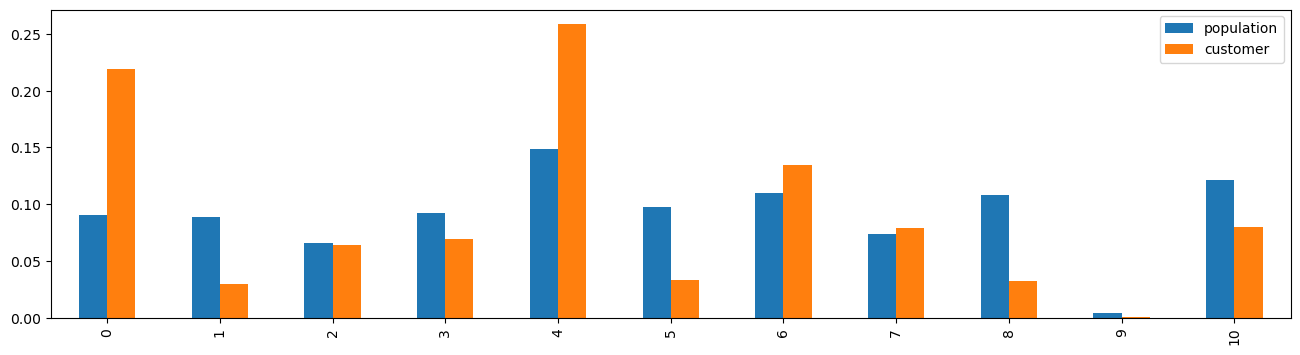

In [465]:
pop_pred = predictions.tolist()
cust_pred = predictions_cust['labels'].tolist()  # Assuming 'labels' is the column containing predictions
lenthpop = len(pop_pred)
lengthcust = len(cust_pred)
valuess = []
for i in range(11):
    lenthpred = len(pop_pred)
    predpop = (pop_pred.count(i))
    custc = (cust_pred.count(i))
    #print(i, predc, custc )
    v = {'population':predpop / lenthpop, 'customer':custc / lengthcust}
    valuess.append(v)
vals = pd.DataFrame(valuess)
vals.plot.bar(figsize=(16,4));
print('Cluster no.5 and 7 are those which represented the customer population')
print('Cluster 2 and 3 of the customer are over represented')
print('Note! Data might change if classifier re-run')


- Clusters 5 and 7 most accurately represent the customer population.
- Clusters 2 and 3 are favored among customer segments.
- Clusters 1, 8, 9, and 10 are less popular among customer segments, with 10 being the least favored.
  

In [466]:
cluster0 = customers_df_1[customers_df_1['labels'] == 0]
cluster1 = customers_df_1[customers_df_1['labels'] == 1]
cluster2 = customers_df_1[customers_df_1['labels'] == 2]
cluster3 = customers_df_1[customers_df_1['labels'] == 3]
cluster4 = customers_df_1[customers_df_1['labels'] == 4]
cluster5 = customers_df_1[customers_df_1['labels'] == 5]
cluster6 = customers_df_1[customers_df_1['labels'] == 6]
cluster7 = customers_df_1[customers_df_1['labels'] == 7]
cluster8 = customers_df_1[customers_df_1['labels'] == 8]
cluster9 = customers_df_1[customers_df_1['labels'] == 9]
cluster10 = customers_df_1[customers_df_1['labels'] == 10]

### Observation 1: Clusters 5 and 7 Best Represented the Customer Population and Displayed Correlation.

The analysis focused on the top 3 features with the highest weight.

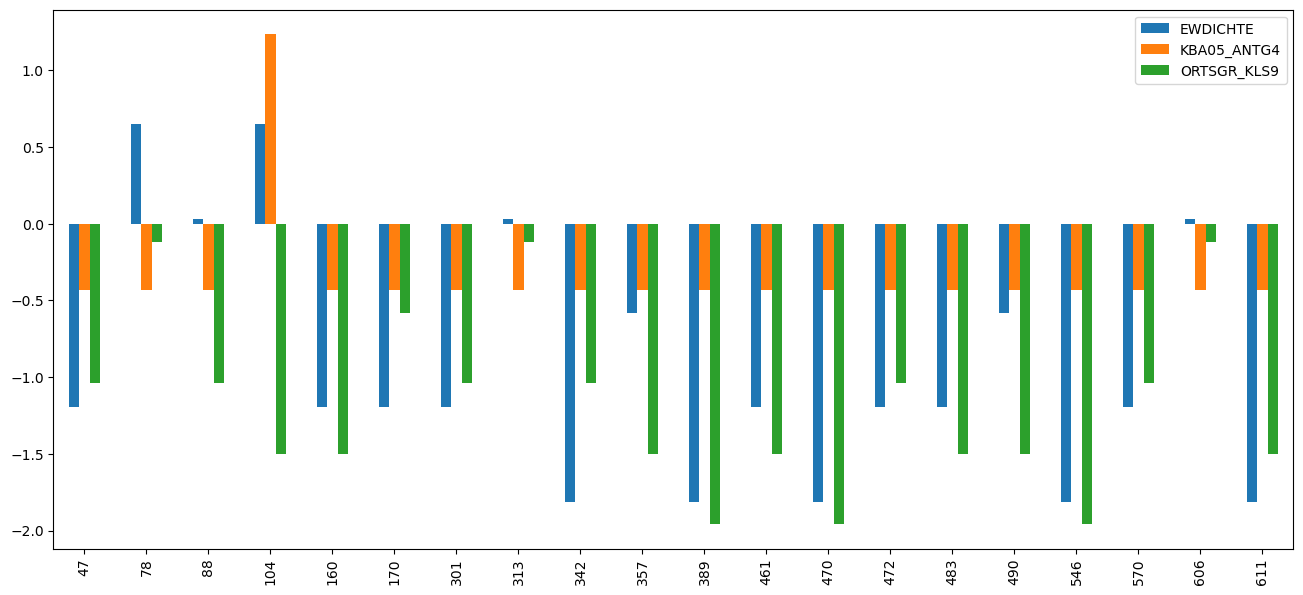

In [467]:
#df2 = pd.DataFrame(cluster5.columns=['EWDICHTE', 'KBA05_ANTG4', 'ORTSGR_KLS9'])
df5 = cluster5[['EWDICHTE', 'KBA05_ANTG4', 'ORTSGR_KLS9']];
df5[:20].plot.bar(figsize=(16,7));

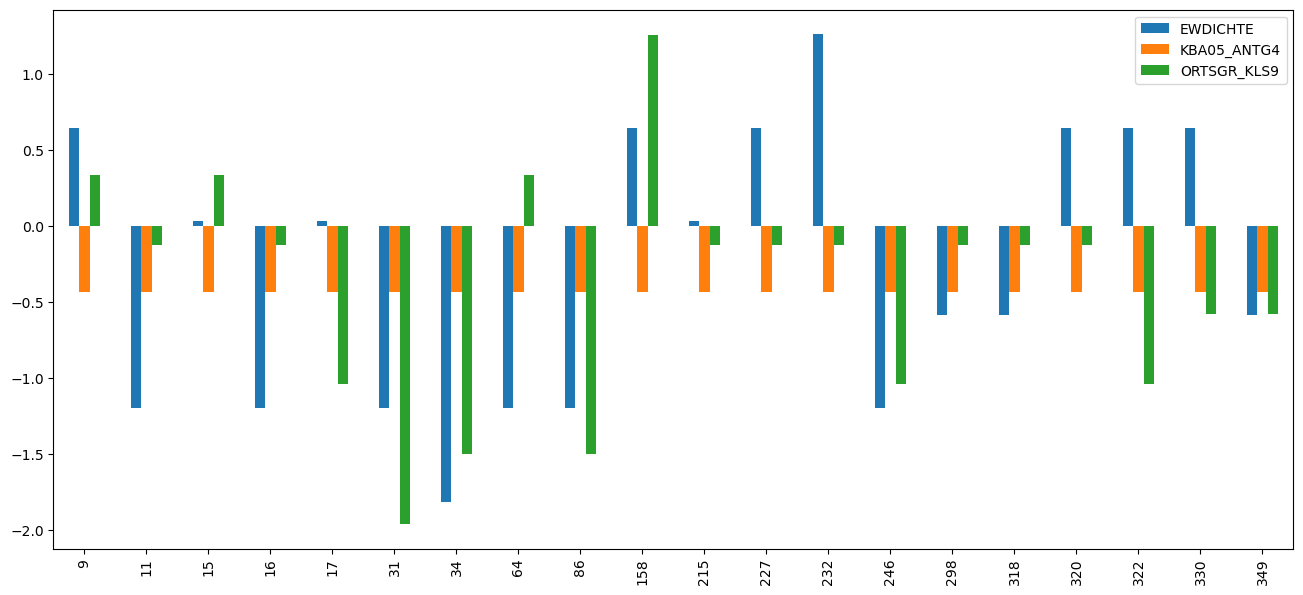

In [468]:
df7 = cluster7[['EWDICHTE', 'KBA05_ANTG4', 'ORTSGR_KLS9']];
df7[:20].plot.bar(figsize=(16,7));

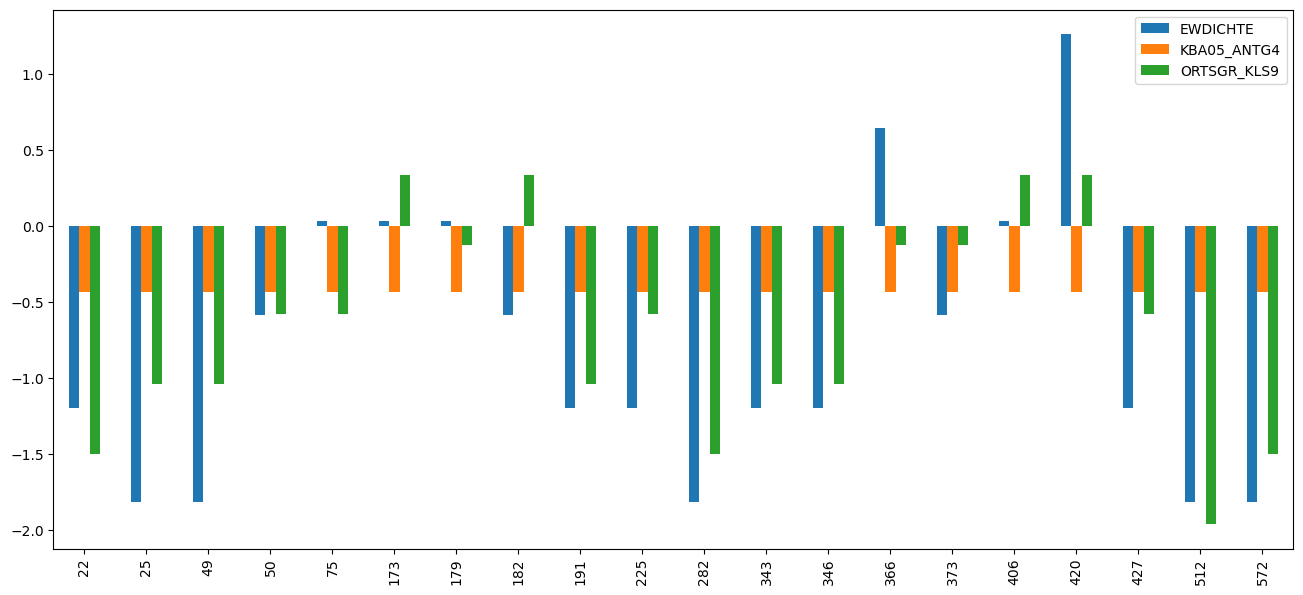

In [469]:
df1 = cluster1[['EWDICHTE', 'KBA05_ANTG4', 'ORTSGR_KLS9']];
df1[:20].plot.bar(figsize=(16,7));

The three bar charts above illustrate the top three features with the highest weights:
1. EWDICHTE - Density of households per square kilometer
2. KBA05_ANTG4 - Number of 10+ family houses in the microcell
3. ORTSGR_KLS9 - Size of community

Clusters 5 and 7 exhibit a consistent trend, indicating a strong correlation among these features in our dataset. Conversely, the graph for cluster 1 serves as a benchmark, showing no correlation with clusters 5 and 7.

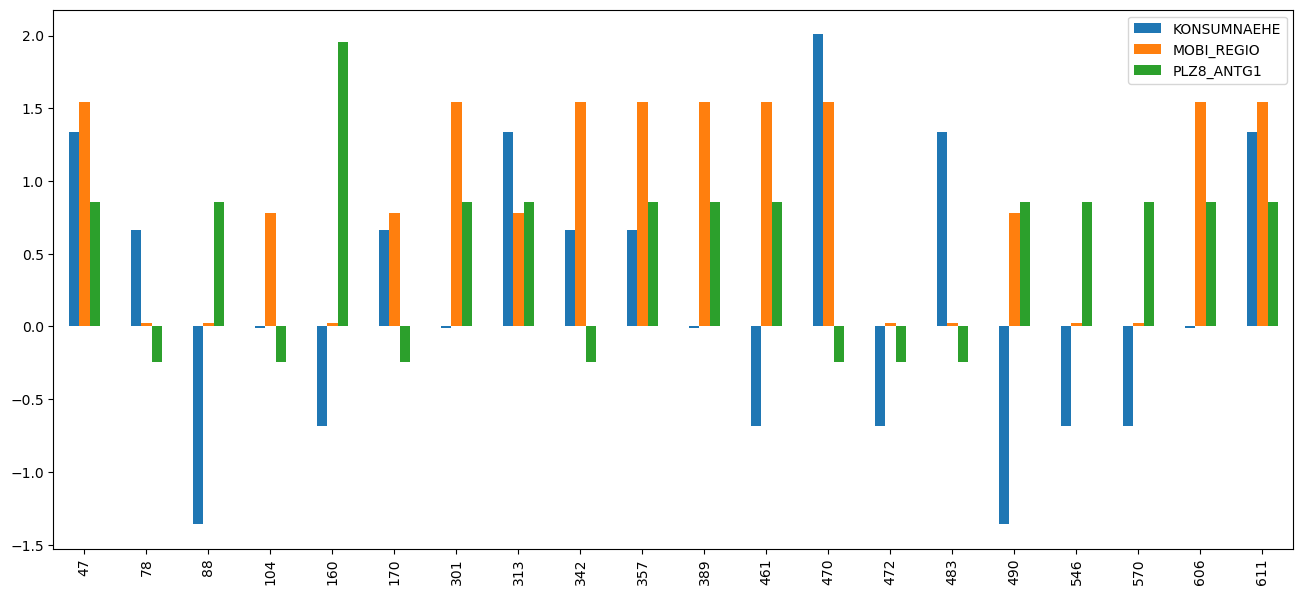

In [470]:
df5_low = cluster5[['KONSUMNAEHE', 'MOBI_REGIO', 'PLZ8_ANTG1']];
df5_low[:20].plot.bar(figsize=(16,7));

In [471]:
df7_low = cluster7[['KONSUMNAEHE', 'MOBI_REGIO', 'PLZ8_ANTG1']];
df5_low = cluster5[['KONSUMNAEHE', 'MOBI_REGIO', 'PLZ8_ANTG1']];


The two bar charts above depict the lowest three features with the lowest weights:
1. KONSUMNAEHE - Distance from building to point of sale (PoS)
2. MOBI_REGIO - Movement patterns
3. PLZ8_ANTG1 - Number of 1-2 family houses in the PLZ8 region

These features exhibit low weights, indicating minimal correlation, as reflected in the charts.

### Observation 2: Cluster 2 and 3 were favored by customer segments.

We will now examine and analyze their respective features.

### Online Affinity

- 0: None
- 1: Low
- 2: Middle
- 3: High
- 4: Very High
- 5: Highest

The histogram depicts individuals with minimal online affinity.

<Axes: >

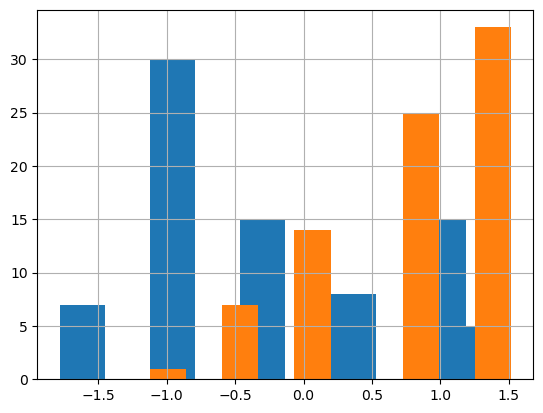

In [472]:
cluster2['ONLINE_AFFINITAET'].head(80).hist()
cluster3['ONLINE_AFFINITAET'].head(80).hist()

#### Household Wealth

- 1: Wealthy
- 2: Prosperous
- 3: Comfortable
- 4: Less Affluent
- 5: Poor

The bar chart below indicates popularity among Wealthy and Prosperous households.

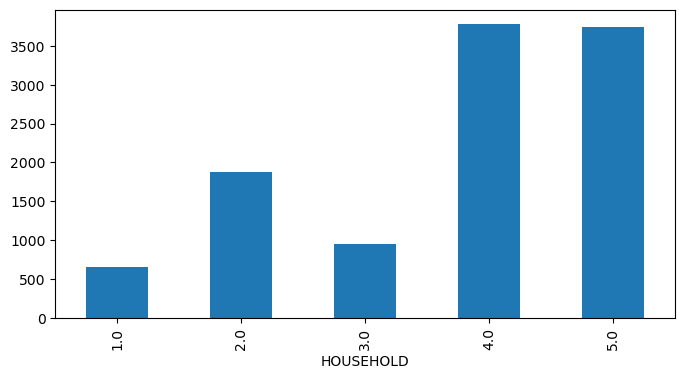

In [473]:
cluster2.groupby('HOUSEHOLD')['HOUSEHOLD'].count().plot.bar(figsize=(8,4));
plt.show()
# cluster3['HOUSEHOLD'] - No data avalaible, Lets look at the third most popular cluster then
#cluster3.groupby('HOUSEHOLD')['HOUSEHOLD'].count().plot.bar(figsize=(8,4));
#plt.show()

#### Generation

- 1: 40s
- 2: 50s
- 3: 60s
- 4: 70s
- 5: 80s
- 6: 90s

The bar chart below illustrates that mail is popular among the older generation, starting from the 50s and gradually declining until the 70s, eventually tapering off as it reaches the millennials. This trend is likely due to the preference of the younger generation for electronic communication methods.

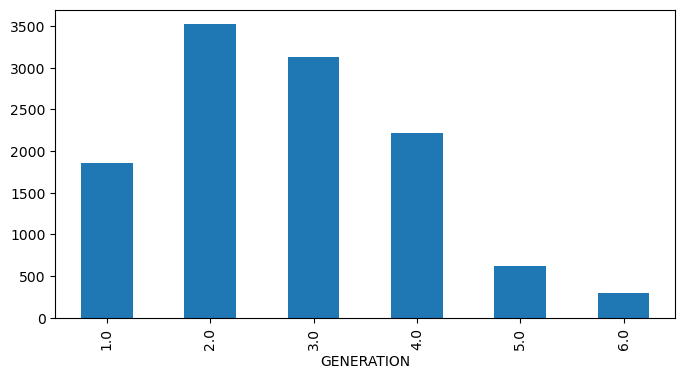

In [474]:
cluster2.groupby('GENERATION')['GENERATION'].count().plot.bar(figsize=(8,4));
plt.show()
#cluster3.groupby('GENERATION')['GENERATION'].count().plot.bar(figsize=(8,4));
#plt.show()


#### Lifestyle

- 1: Pre-Family Couples & Singles
- 2: Young Couples With Children
- 3: Families With School Age Children
- 4: Older Families & Mature Couples
- 5: Elders In Retirement

The trend indicates a preference among more mature and older families, particularly elders in their twilight years.

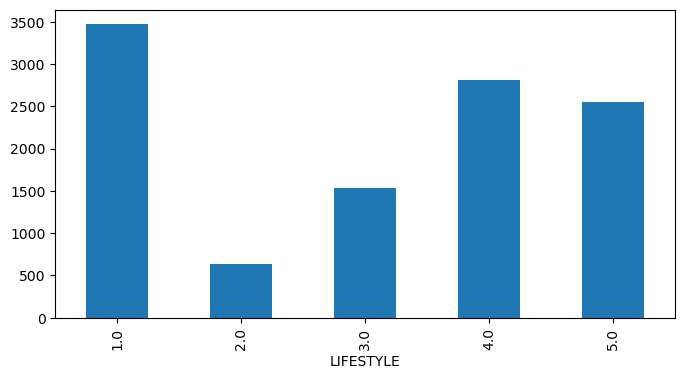

In [475]:
cluster2.groupby('LIFESTYLE')['LIFESTYLE'].count().plot.bar(figsize=(8,4));
plt.show()

#### Financial Typology

- 1: Very High
- 2: High
- 3: Average
- 4: Low
- 5: Very Low

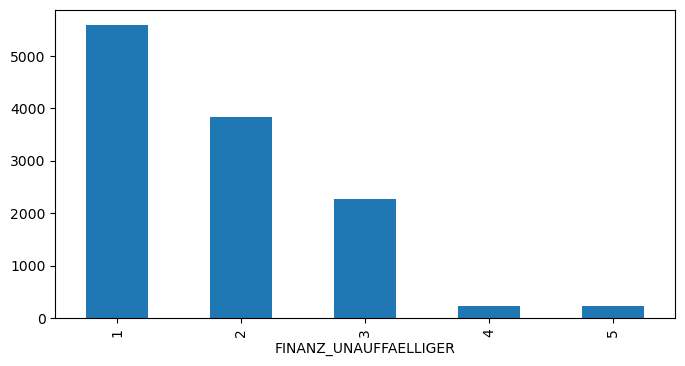

In [476]:
cluster2.groupby('FINANZ_UNAUFFAELLIGER')['FINANZ_UNAUFFAELLIGER'].count().plot.bar(figsize=(8,4));
plt.show()


#### Personality - materialistic
-  1: highest affinity
-  2: very high affinity
-  3: high affinity
-  4: average affinity
-  5: low affinity
-  6: very low affinity
-  7: lowest affinity
-  9: unknown

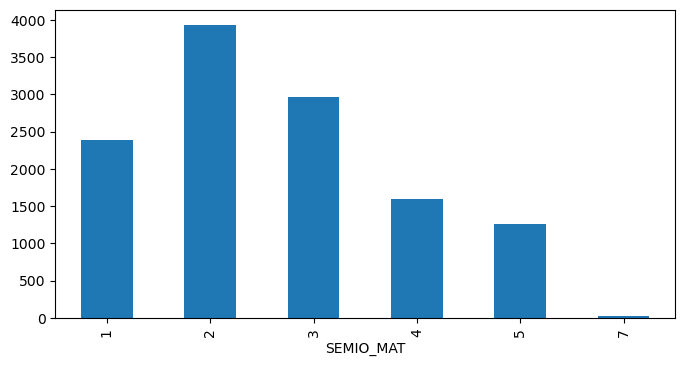

In [477]:
cluster2.groupby('SEMIO_MAT')['SEMIO_MAT'].count().plot.bar(figsize=(8,4));
plt.show()


In [478]:
#cluster2.info()

### Observation 3

Clusters 1, 8, 9, and 10 exhibited low popularity among customer segments, with Cluster 10 being the least popular. Let's analyze Cluster 3, which shares similar features.

### Cluster 10 - Observations

Cluster 10 exhibits features that would typically make it an attractive candidate. However, despite these favorable attributes, it appears to possess characteristics that make it an unlikely choice:

- High online affinity
- Very low affinity to materialistic desires
- Average financial status



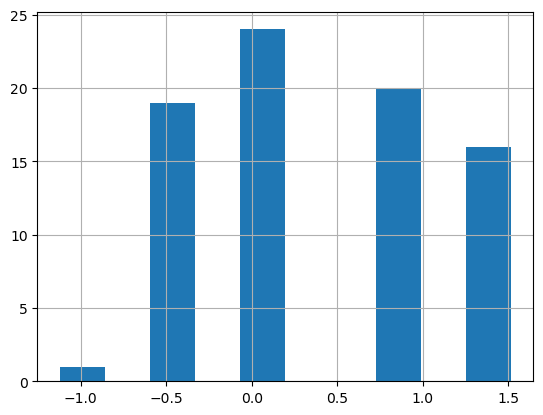

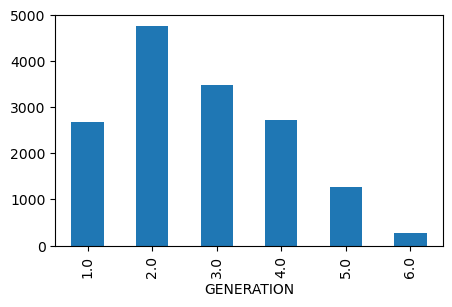

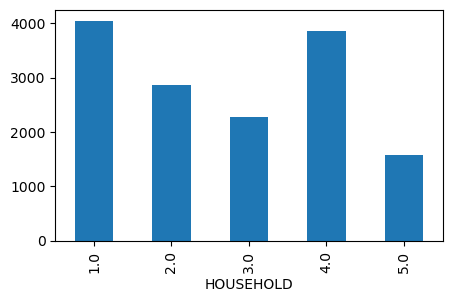

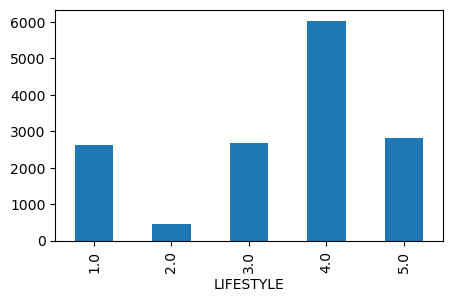

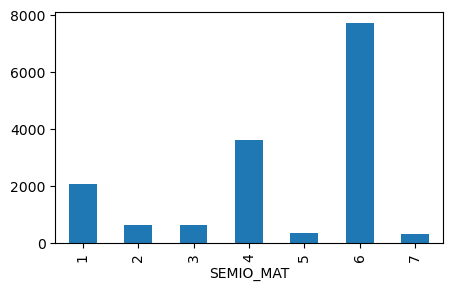

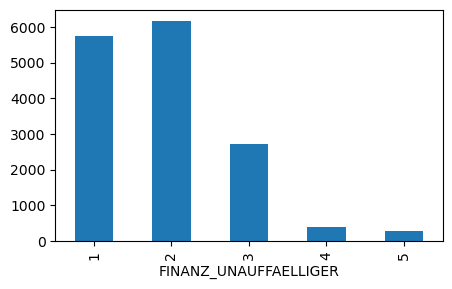

In [479]:
cluster10['ONLINE_AFFINITAET'].head(80).hist()
plt.show()
cluster10.groupby('GENERATION')['GENERATION'].count().plot.bar(figsize=(5,3));
plt.show()
cluster10.groupby('HOUSEHOLD')['HOUSEHOLD'].count().plot.bar(figsize=(5,3));
plt.show()
cluster10.groupby('LIFESTYLE')['LIFESTYLE'].count().plot.bar(figsize=(5,3));
plt.show()
cluster10.groupby('SEMIO_MAT')['SEMIO_MAT'].count().plot.bar(figsize=(5,3));
plt.show()
cluster10.groupby('FINANZ_UNAUFFAELLIGER')['FINANZ_UNAUFFAELLIGER'].count().plot.bar(figsize=(5,3));
plt.show()

### Cluster 1 - Observations

Cluster 1 displays a higher score among the general population but a lower score for the company. This disparity is likely due to the cluster's composition, which consists predominantly of young individuals who are unlikely to prefer mail services. Despite this, they exhibit promising characteristics such as wealth and a materialistic personality. Additionally, they have significant internet access, if not the highest.

Note that cluster 1 consists of the younger generation


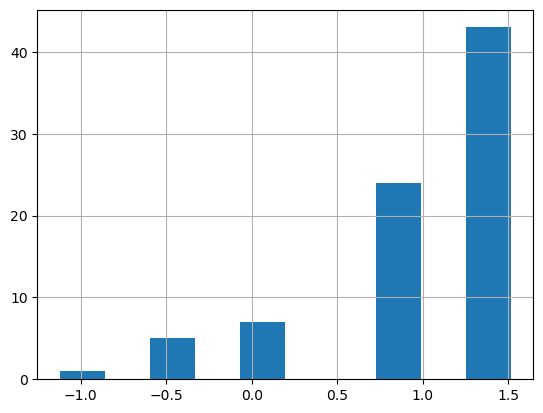

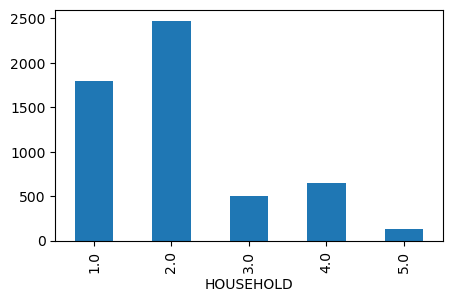

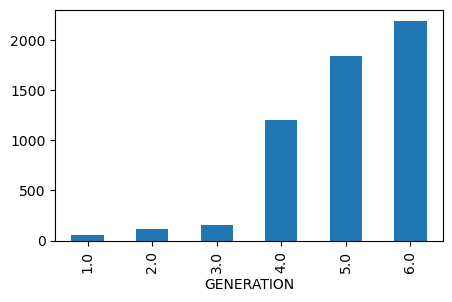

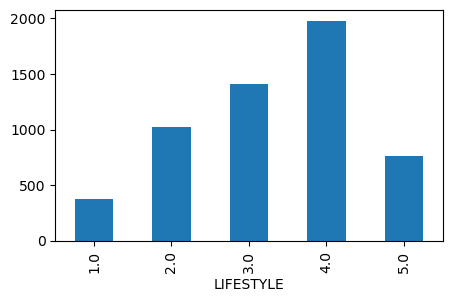

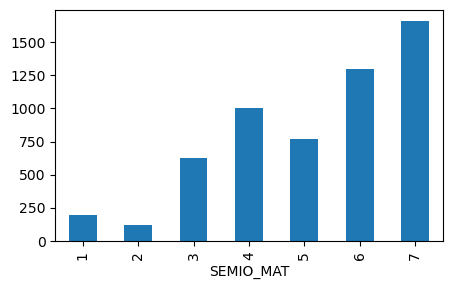

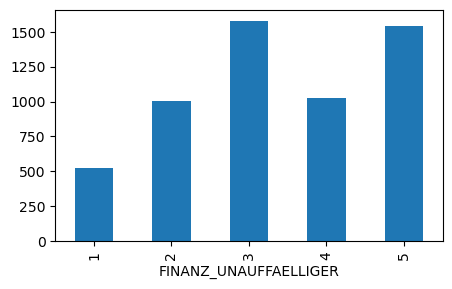

In [480]:
print('Note that cluster 1 consists of the younger generation')
cluster1['ONLINE_AFFINITAET'].head(80).hist()
plt.show()
cluster1.groupby('HOUSEHOLD')['HOUSEHOLD'].count().plot.bar(figsize=(5,3));
plt.show()
cluster1.groupby('GENERATION')['GENERATION'].count().plot.bar(figsize=(5,3));
plt.show()
cluster1.groupby('LIFESTYLE')['LIFESTYLE'].count().plot.bar(figsize=(5,3));
plt.show()
cluster1.groupby('SEMIO_MAT')['SEMIO_MAT'].count().plot.bar(figsize=(5,3));
plt.show()
cluster1.groupby('FINANZ_UNAUFFAELLIGER')['FINANZ_UNAUFFAELLIGER'].count().plot.bar(figsize=(5,3));
plt.show()

### Discussion 3.3: Compare Customer Data to Demographics Data

- The need for separating values, as indicated in step 1.1.3, is unnecessary. Analysis revealed that after separating features, there was minimal impact on the overall dataset's shape and dimensions, thus eliminating the need for additional clustering.

- The characteristics of both popular and unpopular segments/clusters have been thoroughly elucidated.

In conclusion, the bank should target customers who exhibit the following traits:
- Belong to the older generation (40-65 years old).
- Display materialistic tendencies.
- Possess a higher financial status.
- Reside in older families with children and are in their later years.
- Belong to prosperous or financially stable households.
- Have limited or no internet access (low online affinity).

Conversely, the bank should steer clear of customers who:
- Belong to the younger generation.
- Have significant internet access (high online affinity).
- Exhibit a low financial status.
- Are young couples or newly married individuals.